# NN to classifie handwriten numbers with pytorch
In this document the pytorch library is implemented and tested to recognize handwritten numbers. 

The following repository was used as training and validation datenset: https://github.com/kensanata/numbers

First the trainings and validation data is loaded. Afterwards the model is implemented and trained. An evaluation checks whether overfitting is present. A test on a real image tests the usability in practice.

## Summary
The test works very well overall. First there were problems in the recognition of the number three. This was recognized as nine. By increasing the hidden layers the problem could be solved.

## Author
Jeroen Andreß, M.Sc. Professional software developer.

## References
* [1]: https://www.youtube.com/watch?v=pylvlMuRKY0&list=PLNmsVeXQZj7rx55Mai21reZtd_8m-qe27

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision

import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

from PIL import Image
import PIL.ImageOps

import itertools

## Download test and training data

The training and evaluation data were divided in a ratio of 8:2. As batch size 64 was selected. The images are scaled down to 28x28, so the calculation effort is greatly reduced while the results remain the same.

In [2]:
def create_data_from_image_list(image_file_list, batch_size):
    data = []                        

    for i in range(0, len(image_file_list), batch_size):
        data_list = []
        target_list = []

        for image_path, number in image_file_list[i:i+batch_size]:
            target = [1 if i == number else 0 for i in range(10)]
            image = Image.open(image_path).convert('L')
            image_tensor = transforms(image)
            data_list.append(image_tensor)
            target_list.append(torch.Tensor(target))

        data.append((torch.stack(data_list), torch.stack(target_list)))

        print('Loaded batch {:3} of {} ({:3.2f}%)'.
              format(
                  int(i / batch_size), 
                  int(len(image_file_list) / batch_size), 
                  100 * int(i / batch_size) / int(len(image_file_list) / batch_size)))
        
    return data

In [3]:
numbers_dir = './Third-party/numbers/'
batch_size = 64

transforms = transforms.Compose(
    [
        transforms.Resize((28,28)), 
        transforms.CenterCrop(28), 
        transforms.ToTensor(), 
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406], 
            std = [0.229, 0.224, 0.225]
        )
    ])
    
image_file_list = []
for dataset_dir in sorted(os.listdir(numbers_dir)):
    dataset_dir = os.path.join(numbers_dir, dataset_dir)
    if os.path.isdir(dataset_dir) and not dataset_dir.endswith('.git') and not dataset_dir.endswith('example') and not dataset_dir.endswith('tools'):
        for i in range(10):
            current_path = os.path.join(dataset_dir, str(i))
            if os.path.isdir(current_path):
                for image_path in sorted(os.listdir(current_path)):
                    image_path = os.path.join(current_path, image_path)
                    if image_path.endswith('.png'):
                        image_file_list.append((image_path, i))

np.random.shuffle(image_file_list)

split_train_test_data = int(.8 * len(image_file_list))

print('Load train data:')
train_data = create_data_from_image_list(image_file_list=image_file_list[:split_train_test_data], batch_size=batch_size)

print('Load test data:')
test_data = create_data_from_image_list(image_file_list=image_file_list[split_train_test_data:], batch_size=batch_size)

Load train data:
Loaded batch   0 of 190 (0.00%)
Loaded batch   1 of 190 (0.53%)
Loaded batch   2 of 190 (1.05%)
Loaded batch   3 of 190 (1.58%)
Loaded batch   4 of 190 (2.11%)
Loaded batch   5 of 190 (2.63%)
Loaded batch   6 of 190 (3.16%)
Loaded batch   7 of 190 (3.68%)
Loaded batch   8 of 190 (4.21%)
Loaded batch   9 of 190 (4.74%)
Loaded batch  10 of 190 (5.26%)
Loaded batch  11 of 190 (5.79%)
Loaded batch  12 of 190 (6.32%)
Loaded batch  13 of 190 (6.84%)
Loaded batch  14 of 190 (7.37%)
Loaded batch  15 of 190 (7.89%)
Loaded batch  16 of 190 (8.42%)
Loaded batch  17 of 190 (8.95%)
Loaded batch  18 of 190 (9.47%)
Loaded batch  19 of 190 (10.00%)
Loaded batch  20 of 190 (10.53%)
Loaded batch  21 of 190 (11.05%)
Loaded batch  22 of 190 (11.58%)
Loaded batch  23 of 190 (12.11%)
Loaded batch  24 of 190 (12.63%)
Loaded batch  25 of 190 (13.16%)
Loaded batch  26 of 190 (13.68%)
Loaded batch  27 of 190 (14.21%)
Loaded batch  28 of 190 (14.74%)
Loaded batch  29 of 190 (15.26%)
Loaded batch

## Implement NN class
The neural network was constructed as follows:
1. Convolution layer with max pooling as activation function and relu
2. Convolution layer with max pooling as activation function and relu
3. Dropout to prevent overfitting
3. Fully connected layer (Hidden, 100 Nodes, Relu) 
4. Fully connected layer (Output, 10 Nodes, Sigmoid)

In [4]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv_dropout(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)


## Training
Adam was used as training algorithm. binary_cross_entropy was used as error function.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch:  0 [    0 / 12160 (  0%)]	Loss: 0.661721 
Train Epoch:  0 [   64 / 12160 (  1%)]	Loss: 0.628244 
Train Epoch:  0 [  128 / 12160 (  1%)]	Loss: 0.567298 
Train Epoch:  0 [  192 / 12160 (  2%)]	Loss: 0.409084 
Train Epoch:  0 [  256 / 12160 (  2%)]	Loss: 0.374590 
Train Epoch:  0 [  320 / 12160 (  3%)]	Loss: 0.492018 
Train Epoch:  0 [  384 / 12160 (  3%)]	Loss: 0.407552 
Train Epoch:  0 [  448 / 12160 (  4%)]	Loss: 0.384925 
Train Epoch:  0 [  512 / 12160 (  4%)]	Loss: 0.376009 
Train Epoch:  0 [  576 / 12160 (  5%)]	Loss: 0.383195 
Train Epoch:  0 [  640 / 12160 (  5%)]	Loss: 0.364258 
Train Epoch:  0 [  704 / 12160 (  6%)]	Loss: 0.365416 
Train Epoch:  0 [  768 / 12160 (  6%)]	Loss: 0.365154 
Train Epoch:  0 [  832 / 12160 (  7%)]	Loss: 0.360244 
Train Epoch:  0 [  896 / 12160 (  7%)]	Loss: 0.358016 
Train Epoch:  0 [  960 / 12160 (  8%)]	Loss: 0.358497 
Train Epoch:  0 [ 1024 / 12160 (  8%)]	Loss: 0.345921 
Train Epoch:  0 [ 1088 / 12160 (  9%)]	Loss: 0.353879 
Train Epoc

Train Epoch:  0 [ 9664 / 12160 ( 79%)]	Loss: 0.326618 
Train Epoch:  0 [ 9728 / 12160 ( 80%)]	Loss: 0.331070 
Train Epoch:  0 [ 9792 / 12160 ( 81%)]	Loss: 0.330861 
Train Epoch:  0 [ 9856 / 12160 ( 81%)]	Loss: 0.330657 
Train Epoch:  0 [ 9920 / 12160 ( 82%)]	Loss: 0.337101 
Train Epoch:  0 [ 9984 / 12160 ( 82%)]	Loss: 0.336495 
Train Epoch:  0 [10048 / 12160 ( 83%)]	Loss: 0.330985 
Train Epoch:  0 [10112 / 12160 ( 83%)]	Loss: 0.328934 
Train Epoch:  0 [10176 / 12160 ( 84%)]	Loss: 0.328604 
Train Epoch:  0 [10240 / 12160 ( 84%)]	Loss: 0.326043 
Train Epoch:  0 [10304 / 12160 ( 85%)]	Loss: 0.330828 
Train Epoch:  0 [10368 / 12160 ( 85%)]	Loss: 0.331672 
Train Epoch:  0 [10432 / 12160 ( 86%)]	Loss: 0.325434 
Train Epoch:  0 [10496 / 12160 ( 86%)]	Loss: 0.329131 
Train Epoch:  0 [10560 / 12160 ( 87%)]	Loss: 0.331937 
Train Epoch:  0 [10624 / 12160 ( 87%)]	Loss: 0.330074 
Train Epoch:  0 [10688 / 12160 ( 88%)]	Loss: 0.332968 
Train Epoch:  0 [10752 / 12160 ( 88%)]	Loss: 0.330781 
Train Epoc

Train Epoch:  1 [ 7360 / 12160 ( 61%)]	Loss: 0.326177 
Train Epoch:  1 [ 7424 / 12160 ( 61%)]	Loss: 0.327165 
Train Epoch:  1 [ 7488 / 12160 ( 62%)]	Loss: 0.323814 
Train Epoch:  1 [ 7552 / 12160 ( 62%)]	Loss: 0.324644 
Train Epoch:  1 [ 7616 / 12160 ( 63%)]	Loss: 0.323999 
Train Epoch:  1 [ 7680 / 12160 ( 63%)]	Loss: 0.330416 
Train Epoch:  1 [ 7744 / 12160 ( 64%)]	Loss: 0.329674 
Train Epoch:  1 [ 7808 / 12160 ( 64%)]	Loss: 0.325237 
Train Epoch:  1 [ 7872 / 12160 ( 65%)]	Loss: 0.326262 
Train Epoch:  1 [ 7936 / 12160 ( 65%)]	Loss: 0.319664 
Train Epoch:  1 [ 8000 / 12160 ( 66%)]	Loss: 0.321844 
Train Epoch:  1 [ 8064 / 12160 ( 66%)]	Loss: 0.322406 
Train Epoch:  1 [ 8128 / 12160 ( 67%)]	Loss: 0.331769 
Train Epoch:  1 [ 8192 / 12160 ( 67%)]	Loss: 0.329380 
Train Epoch:  1 [ 8256 / 12160 ( 68%)]	Loss: 0.325598 
Train Epoch:  1 [ 8320 / 12160 ( 68%)]	Loss: 0.327022 
Train Epoch:  1 [ 8384 / 12160 ( 69%)]	Loss: 0.321243 
Train Epoch:  1 [ 8448 / 12160 ( 69%)]	Loss: 0.325321 
Train Epoc

Train Epoch:  2 [ 5248 / 12160 ( 43%)]	Loss: 0.315948 
Train Epoch:  2 [ 5312 / 12160 ( 44%)]	Loss: 0.312824 
Train Epoch:  2 [ 5376 / 12160 ( 44%)]	Loss: 0.319494 
Train Epoch:  2 [ 5440 / 12160 ( 45%)]	Loss: 0.318273 
Train Epoch:  2 [ 5504 / 12160 ( 45%)]	Loss: 0.320087 
Train Epoch:  2 [ 5568 / 12160 ( 46%)]	Loss: 0.317814 
Train Epoch:  2 [ 5632 / 12160 ( 46%)]	Loss: 0.321710 
Train Epoch:  2 [ 5696 / 12160 ( 47%)]	Loss: 0.312936 
Train Epoch:  2 [ 5760 / 12160 ( 47%)]	Loss: 0.307607 
Train Epoch:  2 [ 5824 / 12160 ( 48%)]	Loss: 0.315148 
Train Epoch:  2 [ 5888 / 12160 ( 48%)]	Loss: 0.313164 
Train Epoch:  2 [ 5952 / 12160 ( 49%)]	Loss: 0.315466 
Train Epoch:  2 [ 6016 / 12160 ( 49%)]	Loss: 0.313486 
Train Epoch:  2 [ 6080 / 12160 ( 50%)]	Loss: 0.309717 
Train Epoch:  2 [ 6144 / 12160 ( 51%)]	Loss: 0.312267 
Train Epoch:  2 [ 6208 / 12160 ( 51%)]	Loss: 0.312836 
Train Epoch:  2 [ 6272 / 12160 ( 52%)]	Loss: 0.307266 
Train Epoch:  2 [ 6336 / 12160 ( 52%)]	Loss: 0.315000 
Train Epoc

Train Epoch:  3 [ 2880 / 12160 ( 24%)]	Loss: 0.279349 
Train Epoch:  3 [ 2944 / 12160 ( 24%)]	Loss: 0.286386 
Train Epoch:  3 [ 3008 / 12160 ( 25%)]	Loss: 0.278959 
Train Epoch:  3 [ 3072 / 12160 ( 25%)]	Loss: 0.283544 
Train Epoch:  3 [ 3136 / 12160 ( 26%)]	Loss: 0.260498 
Train Epoch:  3 [ 3200 / 12160 ( 26%)]	Loss: 0.276468 
Train Epoch:  3 [ 3264 / 12160 ( 27%)]	Loss: 0.270235 
Train Epoch:  3 [ 3328 / 12160 ( 27%)]	Loss: 0.249674 
Train Epoch:  3 [ 3392 / 12160 ( 28%)]	Loss: 0.291067 
Train Epoch:  3 [ 3456 / 12160 ( 28%)]	Loss: 0.251841 
Train Epoch:  3 [ 3520 / 12160 ( 29%)]	Loss: 0.266246 
Train Epoch:  3 [ 3584 / 12160 ( 29%)]	Loss: 0.264634 
Train Epoch:  3 [ 3648 / 12160 ( 30%)]	Loss: 0.245899 
Train Epoch:  3 [ 3712 / 12160 ( 31%)]	Loss: 0.283636 
Train Epoch:  3 [ 3776 / 12160 ( 31%)]	Loss: 0.248964 
Train Epoch:  3 [ 3840 / 12160 ( 32%)]	Loss: 0.239077 
Train Epoch:  3 [ 3904 / 12160 ( 32%)]	Loss: 0.275825 
Train Epoch:  3 [ 3968 / 12160 ( 33%)]	Loss: 0.255912 
Train Epoc

Train Epoch:  4 [  704 / 12160 (  6%)]	Loss: 0.187200 
Train Epoch:  4 [  768 / 12160 (  6%)]	Loss: 0.231003 
Train Epoch:  4 [  832 / 12160 (  7%)]	Loss: 0.202370 
Train Epoch:  4 [  896 / 12160 (  7%)]	Loss: 0.207569 
Train Epoch:  4 [  960 / 12160 (  8%)]	Loss: 0.232849 
Train Epoch:  4 [ 1024 / 12160 (  8%)]	Loss: 0.194010 
Train Epoch:  4 [ 1088 / 12160 (  9%)]	Loss: 0.210284 
Train Epoch:  4 [ 1152 / 12160 (  9%)]	Loss: 0.197988 
Train Epoch:  4 [ 1216 / 12160 ( 10%)]	Loss: 0.208343 
Train Epoch:  4 [ 1280 / 12160 ( 11%)]	Loss: 0.229575 
Train Epoch:  4 [ 1344 / 12160 ( 11%)]	Loss: 0.198306 
Train Epoch:  4 [ 1408 / 12160 ( 12%)]	Loss: 0.216172 
Train Epoch:  4 [ 1472 / 12160 ( 12%)]	Loss: 0.204591 
Train Epoch:  4 [ 1536 / 12160 ( 13%)]	Loss: 0.198418 
Train Epoch:  4 [ 1600 / 12160 ( 13%)]	Loss: 0.196994 
Train Epoch:  4 [ 1664 / 12160 ( 14%)]	Loss: 0.192362 
Train Epoch:  4 [ 1728 / 12160 ( 14%)]	Loss: 0.203325 
Train Epoch:  4 [ 1792 / 12160 ( 15%)]	Loss: 0.176609 
Train Epoc

Train Epoch:  4 [10432 / 12160 ( 86%)]	Loss: 0.202343 
Train Epoch:  4 [10496 / 12160 ( 86%)]	Loss: 0.190470 
Train Epoch:  4 [10560 / 12160 ( 87%)]	Loss: 0.189045 
Train Epoch:  4 [10624 / 12160 ( 87%)]	Loss: 0.154190 
Train Epoch:  4 [10688 / 12160 ( 88%)]	Loss: 0.187013 
Train Epoch:  4 [10752 / 12160 ( 88%)]	Loss: 0.198892 
Train Epoch:  4 [10816 / 12160 ( 89%)]	Loss: 0.177979 
Train Epoch:  4 [10880 / 12160 ( 89%)]	Loss: 0.188204 
Train Epoch:  4 [10944 / 12160 ( 90%)]	Loss: 0.186773 
Train Epoch:  4 [11008 / 12160 ( 91%)]	Loss: 0.178678 
Train Epoch:  4 [11072 / 12160 ( 91%)]	Loss: 0.148678 
Train Epoch:  4 [11136 / 12160 ( 92%)]	Loss: 0.161199 
Train Epoch:  4 [11200 / 12160 ( 92%)]	Loss: 0.192727 
Train Epoch:  4 [11264 / 12160 ( 93%)]	Loss: 0.193219 
Train Epoch:  4 [11328 / 12160 ( 93%)]	Loss: 0.160708 
Train Epoch:  4 [11392 / 12160 ( 94%)]	Loss: 0.194924 
Train Epoch:  4 [11456 / 12160 ( 94%)]	Loss: 0.161686 
Train Epoch:  4 [11520 / 12160 ( 95%)]	Loss: 0.134262 
Train Epoc

Train Epoch:  5 [ 8128 / 12160 ( 67%)]	Loss: 0.148569 
Train Epoch:  5 [ 8192 / 12160 ( 67%)]	Loss: 0.123788 
Train Epoch:  5 [ 8256 / 12160 ( 68%)]	Loss: 0.124164 
Train Epoch:  5 [ 8320 / 12160 ( 68%)]	Loss: 0.148220 
Train Epoch:  5 [ 8384 / 12160 ( 69%)]	Loss: 0.131021 
Train Epoch:  5 [ 8448 / 12160 ( 69%)]	Loss: 0.123786 
Train Epoch:  5 [ 8512 / 12160 ( 70%)]	Loss: 0.135496 
Train Epoch:  5 [ 8576 / 12160 ( 71%)]	Loss: 0.146858 
Train Epoch:  5 [ 8640 / 12160 ( 71%)]	Loss: 0.129133 
Train Epoch:  5 [ 8704 / 12160 ( 72%)]	Loss: 0.176137 
Train Epoch:  5 [ 8768 / 12160 ( 72%)]	Loss: 0.145752 
Train Epoch:  5 [ 8832 / 12160 ( 73%)]	Loss: 0.133926 
Train Epoch:  5 [ 8896 / 12160 ( 73%)]	Loss: 0.155053 
Train Epoch:  5 [ 8960 / 12160 ( 74%)]	Loss: 0.152480 
Train Epoch:  5 [ 9024 / 12160 ( 74%)]	Loss: 0.117149 
Train Epoch:  5 [ 9088 / 12160 ( 75%)]	Loss: 0.168350 
Train Epoch:  5 [ 9152 / 12160 ( 75%)]	Loss: 0.122329 
Train Epoch:  5 [ 9216 / 12160 ( 76%)]	Loss: 0.151744 
Train Epoc

Train Epoch:  6 [ 5568 / 12160 ( 46%)]	Loss: 0.121300 
Train Epoch:  6 [ 5632 / 12160 ( 46%)]	Loss: 0.159931 
Train Epoch:  6 [ 5696 / 12160 ( 47%)]	Loss: 0.154841 
Train Epoch:  6 [ 5760 / 12160 ( 47%)]	Loss: 0.088691 
Train Epoch:  6 [ 5824 / 12160 ( 48%)]	Loss: 0.138010 
Train Epoch:  6 [ 5888 / 12160 ( 48%)]	Loss: 0.125271 
Train Epoch:  6 [ 5952 / 12160 ( 49%)]	Loss: 0.150912 
Train Epoch:  6 [ 6016 / 12160 ( 49%)]	Loss: 0.151186 
Train Epoch:  6 [ 6080 / 12160 ( 50%)]	Loss: 0.101931 
Train Epoch:  6 [ 6144 / 12160 ( 51%)]	Loss: 0.098471 
Train Epoch:  6 [ 6208 / 12160 ( 51%)]	Loss: 0.119401 
Train Epoch:  6 [ 6272 / 12160 ( 52%)]	Loss: 0.115066 
Train Epoch:  6 [ 6336 / 12160 ( 52%)]	Loss: 0.119621 
Train Epoch:  6 [ 6400 / 12160 ( 53%)]	Loss: 0.103308 
Train Epoch:  6 [ 6464 / 12160 ( 53%)]	Loss: 0.136971 
Train Epoch:  6 [ 6528 / 12160 ( 54%)]	Loss: 0.125393 
Train Epoch:  6 [ 6592 / 12160 ( 54%)]	Loss: 0.129779 
Train Epoch:  6 [ 6656 / 12160 ( 55%)]	Loss: 0.131756 
Train Epoc

Train Epoch:  7 [ 3136 / 12160 ( 26%)]	Loss: 0.093549 
Train Epoch:  7 [ 3200 / 12160 ( 26%)]	Loss: 0.134621 
Train Epoch:  7 [ 3264 / 12160 ( 27%)]	Loss: 0.111801 
Train Epoch:  7 [ 3328 / 12160 ( 27%)]	Loss: 0.122396 
Train Epoch:  7 [ 3392 / 12160 ( 28%)]	Loss: 0.122814 
Train Epoch:  7 [ 3456 / 12160 ( 28%)]	Loss: 0.097569 
Train Epoch:  7 [ 3520 / 12160 ( 29%)]	Loss: 0.144293 
Train Epoch:  7 [ 3584 / 12160 ( 29%)]	Loss: 0.120852 
Train Epoch:  7 [ 3648 / 12160 ( 30%)]	Loss: 0.103829 
Train Epoch:  7 [ 3712 / 12160 ( 31%)]	Loss: 0.125590 
Train Epoch:  7 [ 3776 / 12160 ( 31%)]	Loss: 0.098458 
Train Epoch:  7 [ 3840 / 12160 ( 32%)]	Loss: 0.105706 
Train Epoch:  7 [ 3904 / 12160 ( 32%)]	Loss: 0.107320 
Train Epoch:  7 [ 3968 / 12160 ( 33%)]	Loss: 0.107854 
Train Epoch:  7 [ 4032 / 12160 ( 33%)]	Loss: 0.098590 
Train Epoch:  7 [ 4096 / 12160 ( 34%)]	Loss: 0.120908 
Train Epoch:  7 [ 4160 / 12160 ( 34%)]	Loss: 0.109320 
Train Epoch:  7 [ 4224 / 12160 ( 35%)]	Loss: 0.140081 
Train Epoc

Train Epoch:  8 [  576 / 12160 (  5%)]	Loss: 0.088677 
Train Epoch:  8 [  640 / 12160 (  5%)]	Loss: 0.100115 
Train Epoch:  8 [  704 / 12160 (  6%)]	Loss: 0.109623 
Train Epoch:  8 [  768 / 12160 (  6%)]	Loss: 0.105257 
Train Epoch:  8 [  832 / 12160 (  7%)]	Loss: 0.078118 
Train Epoch:  8 [  896 / 12160 (  7%)]	Loss: 0.128255 
Train Epoch:  8 [  960 / 12160 (  8%)]	Loss: 0.126881 
Train Epoch:  8 [ 1024 / 12160 (  8%)]	Loss: 0.087258 
Train Epoch:  8 [ 1088 / 12160 (  9%)]	Loss: 0.096500 
Train Epoch:  8 [ 1152 / 12160 (  9%)]	Loss: 0.100429 
Train Epoch:  8 [ 1216 / 12160 ( 10%)]	Loss: 0.110870 
Train Epoch:  8 [ 1280 / 12160 ( 11%)]	Loss: 0.090908 
Train Epoch:  8 [ 1344 / 12160 ( 11%)]	Loss: 0.071614 
Train Epoch:  8 [ 1408 / 12160 ( 12%)]	Loss: 0.088380 
Train Epoch:  8 [ 1472 / 12160 ( 12%)]	Loss: 0.112182 
Train Epoch:  8 [ 1536 / 12160 ( 13%)]	Loss: 0.094024 
Train Epoch:  8 [ 1600 / 12160 ( 13%)]	Loss: 0.098434 
Train Epoch:  8 [ 1664 / 12160 ( 14%)]	Loss: 0.094677 
Train Epoc

Train Epoch:  8 [10432 / 12160 ( 86%)]	Loss: 0.116747 
Train Epoch:  8 [10496 / 12160 ( 86%)]	Loss: 0.107014 
Train Epoch:  8 [10560 / 12160 ( 87%)]	Loss: 0.102301 
Train Epoch:  8 [10624 / 12160 ( 87%)]	Loss: 0.086016 
Train Epoch:  8 [10688 / 12160 ( 88%)]	Loss: 0.123808 
Train Epoch:  8 [10752 / 12160 ( 88%)]	Loss: 0.128409 
Train Epoch:  8 [10816 / 12160 ( 89%)]	Loss: 0.106968 
Train Epoch:  8 [10880 / 12160 ( 89%)]	Loss: 0.101821 
Train Epoch:  8 [10944 / 12160 ( 90%)]	Loss: 0.108371 
Train Epoch:  8 [11008 / 12160 ( 91%)]	Loss: 0.092889 
Train Epoch:  8 [11072 / 12160 ( 91%)]	Loss: 0.097129 
Train Epoch:  8 [11136 / 12160 ( 92%)]	Loss: 0.086434 
Train Epoch:  8 [11200 / 12160 ( 92%)]	Loss: 0.130815 
Train Epoch:  8 [11264 / 12160 ( 93%)]	Loss: 0.074667 
Train Epoch:  8 [11328 / 12160 ( 93%)]	Loss: 0.082042 
Train Epoch:  8 [11392 / 12160 ( 94%)]	Loss: 0.142192 
Train Epoch:  8 [11456 / 12160 ( 94%)]	Loss: 0.084250 
Train Epoch:  8 [11520 / 12160 ( 95%)]	Loss: 0.070040 
Train Epoc

Train Epoch:  9 [ 8256 / 12160 ( 68%)]	Loss: 0.082368 
Train Epoch:  9 [ 8320 / 12160 ( 68%)]	Loss: 0.095058 
Train Epoch:  9 [ 8384 / 12160 ( 69%)]	Loss: 0.077161 
Train Epoch:  9 [ 8448 / 12160 ( 69%)]	Loss: 0.082467 
Train Epoch:  9 [ 8512 / 12160 ( 70%)]	Loss: 0.063561 
Train Epoch:  9 [ 8576 / 12160 ( 71%)]	Loss: 0.088146 
Train Epoch:  9 [ 8640 / 12160 ( 71%)]	Loss: 0.049003 
Train Epoch:  9 [ 8704 / 12160 ( 72%)]	Loss: 0.116272 
Train Epoch:  9 [ 8768 / 12160 ( 72%)]	Loss: 0.082937 
Train Epoch:  9 [ 8832 / 12160 ( 73%)]	Loss: 0.071756 
Train Epoch:  9 [ 8896 / 12160 ( 73%)]	Loss: 0.084851 
Train Epoch:  9 [ 8960 / 12160 ( 74%)]	Loss: 0.088081 
Train Epoch:  9 [ 9024 / 12160 ( 74%)]	Loss: 0.085842 
Train Epoch:  9 [ 9088 / 12160 ( 75%)]	Loss: 0.097564 
Train Epoch:  9 [ 9152 / 12160 ( 75%)]	Loss: 0.066080 
Train Epoch:  9 [ 9216 / 12160 ( 76%)]	Loss: 0.078983 
Train Epoch:  9 [ 9280 / 12160 ( 76%)]	Loss: 0.090949 
Train Epoch:  9 [ 9344 / 12160 ( 77%)]	Loss: 0.091197 
Train Epoc

Train Epoch: 10 [ 5632 / 12160 ( 46%)]	Loss: 0.089495 
Train Epoch: 10 [ 5696 / 12160 ( 47%)]	Loss: 0.095931 
Train Epoch: 10 [ 5760 / 12160 ( 47%)]	Loss: 0.056066 
Train Epoch: 10 [ 5824 / 12160 ( 48%)]	Loss: 0.082989 
Train Epoch: 10 [ 5888 / 12160 ( 48%)]	Loss: 0.064949 
Train Epoch: 10 [ 5952 / 12160 ( 49%)]	Loss: 0.096683 
Train Epoch: 10 [ 6016 / 12160 ( 49%)]	Loss: 0.104525 
Train Epoch: 10 [ 6080 / 12160 ( 50%)]	Loss: 0.104851 
Train Epoch: 10 [ 6144 / 12160 ( 51%)]	Loss: 0.042924 
Train Epoch: 10 [ 6208 / 12160 ( 51%)]	Loss: 0.082035 
Train Epoch: 10 [ 6272 / 12160 ( 52%)]	Loss: 0.116189 
Train Epoch: 10 [ 6336 / 12160 ( 52%)]	Loss: 0.058768 
Train Epoch: 10 [ 6400 / 12160 ( 53%)]	Loss: 0.056888 
Train Epoch: 10 [ 6464 / 12160 ( 53%)]	Loss: 0.109011 
Train Epoch: 10 [ 6528 / 12160 ( 54%)]	Loss: 0.067700 
Train Epoch: 10 [ 6592 / 12160 ( 54%)]	Loss: 0.102418 
Train Epoch: 10 [ 6656 / 12160 ( 55%)]	Loss: 0.113860 
Train Epoch: 10 [ 6720 / 12160 ( 55%)]	Loss: 0.089248 
Train Epoc

Train Epoch: 11 [ 3136 / 12160 ( 26%)]	Loss: 0.091122 
Train Epoch: 11 [ 3200 / 12160 ( 26%)]	Loss: 0.104166 
Train Epoch: 11 [ 3264 / 12160 ( 27%)]	Loss: 0.092387 
Train Epoch: 11 [ 3328 / 12160 ( 27%)]	Loss: 0.067251 
Train Epoch: 11 [ 3392 / 12160 ( 28%)]	Loss: 0.077212 
Train Epoch: 11 [ 3456 / 12160 ( 28%)]	Loss: 0.072328 
Train Epoch: 11 [ 3520 / 12160 ( 29%)]	Loss: 0.104179 
Train Epoch: 11 [ 3584 / 12160 ( 29%)]	Loss: 0.063772 
Train Epoch: 11 [ 3648 / 12160 ( 30%)]	Loss: 0.068637 
Train Epoch: 11 [ 3712 / 12160 ( 31%)]	Loss: 0.089016 
Train Epoch: 11 [ 3776 / 12160 ( 31%)]	Loss: 0.071927 
Train Epoch: 11 [ 3840 / 12160 ( 32%)]	Loss: 0.046654 
Train Epoch: 11 [ 3904 / 12160 ( 32%)]	Loss: 0.095421 
Train Epoch: 11 [ 3968 / 12160 ( 33%)]	Loss: 0.077050 
Train Epoch: 11 [ 4032 / 12160 ( 33%)]	Loss: 0.065350 
Train Epoch: 11 [ 4096 / 12160 ( 34%)]	Loss: 0.076765 
Train Epoch: 11 [ 4160 / 12160 ( 34%)]	Loss: 0.068831 
Train Epoch: 11 [ 4224 / 12160 ( 35%)]	Loss: 0.121375 
Train Epoc

Train Epoch: 12 [  768 / 12160 (  6%)]	Loss: 0.087716 
Train Epoch: 12 [  832 / 12160 (  7%)]	Loss: 0.082544 
Train Epoch: 12 [  896 / 12160 (  7%)]	Loss: 0.097309 
Train Epoch: 12 [  960 / 12160 (  8%)]	Loss: 0.096006 
Train Epoch: 12 [ 1024 / 12160 (  8%)]	Loss: 0.063244 
Train Epoch: 12 [ 1088 / 12160 (  9%)]	Loss: 0.069743 
Train Epoch: 12 [ 1152 / 12160 (  9%)]	Loss: 0.072576 
Train Epoch: 12 [ 1216 / 12160 ( 10%)]	Loss: 0.076661 
Train Epoch: 12 [ 1280 / 12160 ( 11%)]	Loss: 0.085422 
Train Epoch: 12 [ 1344 / 12160 ( 11%)]	Loss: 0.063402 
Train Epoch: 12 [ 1408 / 12160 ( 12%)]	Loss: 0.070419 
Train Epoch: 12 [ 1472 / 12160 ( 12%)]	Loss: 0.084925 
Train Epoch: 12 [ 1536 / 12160 ( 13%)]	Loss: 0.099405 
Train Epoch: 12 [ 1600 / 12160 ( 13%)]	Loss: 0.067944 
Train Epoch: 12 [ 1664 / 12160 ( 14%)]	Loss: 0.069868 
Train Epoch: 12 [ 1728 / 12160 ( 14%)]	Loss: 0.082054 
Train Epoch: 12 [ 1792 / 12160 ( 15%)]	Loss: 0.078845 
Train Epoch: 12 [ 1856 / 12160 ( 15%)]	Loss: 0.073899 
Train Epoc

Train Epoch: 12 [10560 / 12160 ( 87%)]	Loss: 0.074906 
Train Epoch: 12 [10624 / 12160 ( 87%)]	Loss: 0.100795 
Train Epoch: 12 [10688 / 12160 ( 88%)]	Loss: 0.101551 
Train Epoch: 12 [10752 / 12160 ( 88%)]	Loss: 0.093911 
Train Epoch: 12 [10816 / 12160 ( 89%)]	Loss: 0.083680 
Train Epoch: 12 [10880 / 12160 ( 89%)]	Loss: 0.086688 
Train Epoch: 12 [10944 / 12160 ( 90%)]	Loss: 0.093367 
Train Epoch: 12 [11008 / 12160 ( 91%)]	Loss: 0.086949 
Train Epoch: 12 [11072 / 12160 ( 91%)]	Loss: 0.057788 
Train Epoch: 12 [11136 / 12160 ( 92%)]	Loss: 0.072516 
Train Epoch: 12 [11200 / 12160 ( 92%)]	Loss: 0.095140 
Train Epoch: 12 [11264 / 12160 ( 93%)]	Loss: 0.097494 
Train Epoch: 12 [11328 / 12160 ( 93%)]	Loss: 0.071126 
Train Epoch: 12 [11392 / 12160 ( 94%)]	Loss: 0.106339 
Train Epoch: 12 [11456 / 12160 ( 94%)]	Loss: 0.058055 
Train Epoch: 12 [11520 / 12160 ( 95%)]	Loss: 0.065012 
Train Epoch: 12 [11584 / 12160 ( 95%)]	Loss: 0.067142 
Train Epoch: 12 [11648 / 12160 ( 96%)]	Loss: 0.048582 
Train Epoc

Train Epoch: 13 [ 8000 / 12160 ( 66%)]	Loss: 0.064296 
Train Epoch: 13 [ 8064 / 12160 ( 66%)]	Loss: 0.045509 
Train Epoch: 13 [ 8128 / 12160 ( 67%)]	Loss: 0.097957 
Train Epoch: 13 [ 8192 / 12160 ( 67%)]	Loss: 0.049294 
Train Epoch: 13 [ 8256 / 12160 ( 68%)]	Loss: 0.050991 
Train Epoch: 13 [ 8320 / 12160 ( 68%)]	Loss: 0.078989 
Train Epoch: 13 [ 8384 / 12160 ( 69%)]	Loss: 0.046110 
Train Epoch: 13 [ 8448 / 12160 ( 69%)]	Loss: 0.043300 
Train Epoch: 13 [ 8512 / 12160 ( 70%)]	Loss: 0.072064 
Train Epoch: 13 [ 8576 / 12160 ( 71%)]	Loss: 0.073630 
Train Epoch: 13 [ 8640 / 12160 ( 71%)]	Loss: 0.023835 
Train Epoch: 13 [ 8704 / 12160 ( 72%)]	Loss: 0.092061 
Train Epoch: 13 [ 8768 / 12160 ( 72%)]	Loss: 0.086907 
Train Epoch: 13 [ 8832 / 12160 ( 73%)]	Loss: 0.071386 
Train Epoch: 13 [ 8896 / 12160 ( 73%)]	Loss: 0.087170 
Train Epoch: 13 [ 8960 / 12160 ( 74%)]	Loss: 0.073653 
Train Epoch: 13 [ 9024 / 12160 ( 74%)]	Loss: 0.059295 
Train Epoch: 13 [ 9088 / 12160 ( 75%)]	Loss: 0.073800 
Train Epoc

Train Epoch: 14 [ 5632 / 12160 ( 46%)]	Loss: 0.054598 
Train Epoch: 14 [ 5696 / 12160 ( 47%)]	Loss: 0.051349 
Train Epoch: 14 [ 5760 / 12160 ( 47%)]	Loss: 0.044368 
Train Epoch: 14 [ 5824 / 12160 ( 48%)]	Loss: 0.059123 
Train Epoch: 14 [ 5888 / 12160 ( 48%)]	Loss: 0.051765 
Train Epoch: 14 [ 5952 / 12160 ( 49%)]	Loss: 0.107105 
Train Epoch: 14 [ 6016 / 12160 ( 49%)]	Loss: 0.047818 
Train Epoch: 14 [ 6080 / 12160 ( 50%)]	Loss: 0.073498 
Train Epoch: 14 [ 6144 / 12160 ( 51%)]	Loss: 0.045511 
Train Epoch: 14 [ 6208 / 12160 ( 51%)]	Loss: 0.042575 
Train Epoch: 14 [ 6272 / 12160 ( 52%)]	Loss: 0.057810 
Train Epoch: 14 [ 6336 / 12160 ( 52%)]	Loss: 0.069987 
Train Epoch: 14 [ 6400 / 12160 ( 53%)]	Loss: 0.042624 
Train Epoch: 14 [ 6464 / 12160 ( 53%)]	Loss: 0.071630 
Train Epoch: 14 [ 6528 / 12160 ( 54%)]	Loss: 0.048620 
Train Epoch: 14 [ 6592 / 12160 ( 54%)]	Loss: 0.052748 
Train Epoch: 14 [ 6656 / 12160 ( 55%)]	Loss: 0.082875 
Train Epoch: 14 [ 6720 / 12160 ( 55%)]	Loss: 0.098447 
Train Epoc

Train Epoch: 15 [ 3264 / 12160 ( 27%)]	Loss: 0.044969 
Train Epoch: 15 [ 3328 / 12160 ( 27%)]	Loss: 0.042449 
Train Epoch: 15 [ 3392 / 12160 ( 28%)]	Loss: 0.046291 
Train Epoch: 15 [ 3456 / 12160 ( 28%)]	Loss: 0.068659 
Train Epoch: 15 [ 3520 / 12160 ( 29%)]	Loss: 0.067642 
Train Epoch: 15 [ 3584 / 12160 ( 29%)]	Loss: 0.049485 
Train Epoch: 15 [ 3648 / 12160 ( 30%)]	Loss: 0.051938 
Train Epoch: 15 [ 3712 / 12160 ( 31%)]	Loss: 0.052367 
Train Epoch: 15 [ 3776 / 12160 ( 31%)]	Loss: 0.041624 
Train Epoch: 15 [ 3840 / 12160 ( 32%)]	Loss: 0.037255 
Train Epoch: 15 [ 3904 / 12160 ( 32%)]	Loss: 0.084038 
Train Epoch: 15 [ 3968 / 12160 ( 33%)]	Loss: 0.067441 
Train Epoch: 15 [ 4032 / 12160 ( 33%)]	Loss: 0.053548 
Train Epoch: 15 [ 4096 / 12160 ( 34%)]	Loss: 0.049074 
Train Epoch: 15 [ 4160 / 12160 ( 34%)]	Loss: 0.055988 
Train Epoch: 15 [ 4224 / 12160 ( 35%)]	Loss: 0.084106 
Train Epoch: 15 [ 4288 / 12160 ( 35%)]	Loss: 0.063275 
Train Epoch: 15 [ 4352 / 12160 ( 36%)]	Loss: 0.090447 
Train Epoc

Train Epoch: 16 [ 1024 / 12160 (  8%)]	Loss: 0.047316 
Train Epoch: 16 [ 1088 / 12160 (  9%)]	Loss: 0.052231 
Train Epoch: 16 [ 1152 / 12160 (  9%)]	Loss: 0.062807 
Train Epoch: 16 [ 1216 / 12160 ( 10%)]	Loss: 0.085141 
Train Epoch: 16 [ 1280 / 12160 ( 11%)]	Loss: 0.047326 
Train Epoch: 16 [ 1344 / 12160 ( 11%)]	Loss: 0.056062 
Train Epoch: 16 [ 1408 / 12160 ( 12%)]	Loss: 0.066953 
Train Epoch: 16 [ 1472 / 12160 ( 12%)]	Loss: 0.076167 
Train Epoch: 16 [ 1536 / 12160 ( 13%)]	Loss: 0.083788 
Train Epoch: 16 [ 1600 / 12160 ( 13%)]	Loss: 0.045293 
Train Epoch: 16 [ 1664 / 12160 ( 14%)]	Loss: 0.079391 
Train Epoch: 16 [ 1728 / 12160 ( 14%)]	Loss: 0.070469 
Train Epoch: 16 [ 1792 / 12160 ( 15%)]	Loss: 0.057951 
Train Epoch: 16 [ 1856 / 12160 ( 15%)]	Loss: 0.055670 
Train Epoch: 16 [ 1920 / 12160 ( 16%)]	Loss: 0.086879 
Train Epoch: 16 [ 1984 / 12160 ( 16%)]	Loss: 0.070779 
Train Epoch: 16 [ 2048 / 12160 ( 17%)]	Loss: 0.103243 
Train Epoch: 16 [ 2112 / 12160 ( 17%)]	Loss: 0.054855 
Train Epoc

Train Epoch: 16 [11072 / 12160 ( 91%)]	Loss: 0.048460 
Train Epoch: 16 [11136 / 12160 ( 92%)]	Loss: 0.046042 
Train Epoch: 16 [11200 / 12160 ( 92%)]	Loss: 0.078588 
Train Epoch: 16 [11264 / 12160 ( 93%)]	Loss: 0.047771 
Train Epoch: 16 [11328 / 12160 ( 93%)]	Loss: 0.057997 
Train Epoch: 16 [11392 / 12160 ( 94%)]	Loss: 0.104558 
Train Epoch: 16 [11456 / 12160 ( 94%)]	Loss: 0.039368 
Train Epoch: 16 [11520 / 12160 ( 95%)]	Loss: 0.050209 
Train Epoch: 16 [11584 / 12160 ( 95%)]	Loss: 0.056200 
Train Epoch: 16 [11648 / 12160 ( 96%)]	Loss: 0.032512 
Train Epoch: 16 [11712 / 12160 ( 96%)]	Loss: 0.048119 
Train Epoch: 16 [11776 / 12160 ( 97%)]	Loss: 0.073968 
Train Epoch: 16 [11840 / 12160 ( 97%)]	Loss: 0.061720 
Train Epoch: 16 [11904 / 12160 ( 98%)]	Loss: 0.066394 
Train Epoch: 16 [11968 / 12160 ( 98%)]	Loss: 0.070138 
Train Epoch: 16 [12032 / 12160 ( 99%)]	Loss: 0.068246 
Train Epoch: 16 [12096 / 12160 ( 99%)]	Loss: 0.054811 
Train Epoch: 17 [    0 / 12160 (  0%)]	Loss: 0.078205 
Train Epoc

Train Epoch: 17 [ 8640 / 12160 ( 71%)]	Loss: 0.031783 
Train Epoch: 17 [ 8704 / 12160 ( 72%)]	Loss: 0.061208 
Train Epoch: 17 [ 8768 / 12160 ( 72%)]	Loss: 0.061504 
Train Epoch: 17 [ 8832 / 12160 ( 73%)]	Loss: 0.063269 
Train Epoch: 17 [ 8896 / 12160 ( 73%)]	Loss: 0.050797 
Train Epoch: 17 [ 8960 / 12160 ( 74%)]	Loss: 0.050937 
Train Epoch: 17 [ 9024 / 12160 ( 74%)]	Loss: 0.051873 
Train Epoch: 17 [ 9088 / 12160 ( 75%)]	Loss: 0.053093 
Train Epoch: 17 [ 9152 / 12160 ( 75%)]	Loss: 0.038372 
Train Epoch: 17 [ 9216 / 12160 ( 76%)]	Loss: 0.035549 
Train Epoch: 17 [ 9280 / 12160 ( 76%)]	Loss: 0.047639 
Train Epoch: 17 [ 9344 / 12160 ( 77%)]	Loss: 0.091901 
Train Epoch: 17 [ 9408 / 12160 ( 77%)]	Loss: 0.061028 
Train Epoch: 17 [ 9472 / 12160 ( 78%)]	Loss: 0.052801 
Train Epoch: 17 [ 9536 / 12160 ( 78%)]	Loss: 0.083783 
Train Epoch: 17 [ 9600 / 12160 ( 79%)]	Loss: 0.035447 
Train Epoch: 17 [ 9664 / 12160 ( 79%)]	Loss: 0.052555 
Train Epoch: 17 [ 9728 / 12160 ( 80%)]	Loss: 0.067759 
Train Epoc

Train Epoch: 18 [ 6400 / 12160 ( 53%)]	Loss: 0.040528 
Train Epoch: 18 [ 6464 / 12160 ( 53%)]	Loss: 0.085441 
Train Epoch: 18 [ 6528 / 12160 ( 54%)]	Loss: 0.048478 
Train Epoch: 18 [ 6592 / 12160 ( 54%)]	Loss: 0.062132 
Train Epoch: 18 [ 6656 / 12160 ( 55%)]	Loss: 0.077368 
Train Epoch: 18 [ 6720 / 12160 ( 55%)]	Loss: 0.064341 
Train Epoch: 18 [ 6784 / 12160 ( 56%)]	Loss: 0.044246 
Train Epoch: 18 [ 6848 / 12160 ( 56%)]	Loss: 0.058791 
Train Epoch: 18 [ 6912 / 12160 ( 57%)]	Loss: 0.058321 
Train Epoch: 18 [ 6976 / 12160 ( 57%)]	Loss: 0.044571 
Train Epoch: 18 [ 7040 / 12160 ( 58%)]	Loss: 0.043443 
Train Epoch: 18 [ 7104 / 12160 ( 58%)]	Loss: 0.081062 
Train Epoch: 18 [ 7168 / 12160 ( 59%)]	Loss: 0.074662 
Train Epoch: 18 [ 7232 / 12160 ( 59%)]	Loss: 0.050569 
Train Epoch: 18 [ 7296 / 12160 ( 60%)]	Loss: 0.039755 
Train Epoch: 18 [ 7360 / 12160 ( 61%)]	Loss: 0.086095 
Train Epoch: 18 [ 7424 / 12160 ( 61%)]	Loss: 0.036046 
Train Epoch: 18 [ 7488 / 12160 ( 62%)]	Loss: 0.081322 
Train Epoc

Train Epoch: 19 [ 3840 / 12160 ( 32%)]	Loss: 0.033396 
Train Epoch: 19 [ 3904 / 12160 ( 32%)]	Loss: 0.059992 
Train Epoch: 19 [ 3968 / 12160 ( 33%)]	Loss: 0.047428 
Train Epoch: 19 [ 4032 / 12160 ( 33%)]	Loss: 0.033990 
Train Epoch: 19 [ 4096 / 12160 ( 34%)]	Loss: 0.053737 
Train Epoch: 19 [ 4160 / 12160 ( 34%)]	Loss: 0.058355 
Train Epoch: 19 [ 4224 / 12160 ( 35%)]	Loss: 0.071375 
Train Epoch: 19 [ 4288 / 12160 ( 35%)]	Loss: 0.044722 
Train Epoch: 19 [ 4352 / 12160 ( 36%)]	Loss: 0.051529 
Train Epoch: 19 [ 4416 / 12160 ( 36%)]	Loss: 0.080574 
Train Epoch: 19 [ 4480 / 12160 ( 37%)]	Loss: 0.070417 
Train Epoch: 19 [ 4544 / 12160 ( 37%)]	Loss: 0.062783 
Train Epoch: 19 [ 4608 / 12160 ( 38%)]	Loss: 0.070076 
Train Epoch: 19 [ 4672 / 12160 ( 38%)]	Loss: 0.033127 
Train Epoch: 19 [ 4736 / 12160 ( 39%)]	Loss: 0.043280 
Train Epoch: 19 [ 4800 / 12160 ( 39%)]	Loss: 0.033011 
Train Epoch: 19 [ 4864 / 12160 ( 40%)]	Loss: 0.088061 
Train Epoch: 19 [ 4928 / 12160 ( 41%)]	Loss: 0.070506 
Train Epoc

Train Epoch: 20 [ 1472 / 12160 ( 12%)]	Loss: 0.058783 
Train Epoch: 20 [ 1536 / 12160 ( 13%)]	Loss: 0.077947 
Train Epoch: 20 [ 1600 / 12160 ( 13%)]	Loss: 0.035963 
Train Epoch: 20 [ 1664 / 12160 ( 14%)]	Loss: 0.050030 
Train Epoch: 20 [ 1728 / 12160 ( 14%)]	Loss: 0.041365 
Train Epoch: 20 [ 1792 / 12160 ( 15%)]	Loss: 0.064502 
Train Epoch: 20 [ 1856 / 12160 ( 15%)]	Loss: 0.054008 
Train Epoch: 20 [ 1920 / 12160 ( 16%)]	Loss: 0.067590 
Train Epoch: 20 [ 1984 / 12160 ( 16%)]	Loss: 0.061677 
Train Epoch: 20 [ 2048 / 12160 ( 17%)]	Loss: 0.078954 
Train Epoch: 20 [ 2112 / 12160 ( 17%)]	Loss: 0.053915 
Train Epoch: 20 [ 2176 / 12160 ( 18%)]	Loss: 0.055971 
Train Epoch: 20 [ 2240 / 12160 ( 18%)]	Loss: 0.077962 
Train Epoch: 20 [ 2304 / 12160 ( 19%)]	Loss: 0.088114 
Train Epoch: 20 [ 2368 / 12160 ( 19%)]	Loss: 0.080045 
Train Epoch: 20 [ 2432 / 12160 ( 20%)]	Loss: 0.026341 
Train Epoch: 20 [ 2496 / 12160 ( 21%)]	Loss: 0.044136 
Train Epoch: 20 [ 2560 / 12160 ( 21%)]	Loss: 0.056640 
Train Epoc

Train Epoch: 20 [11328 / 12160 ( 93%)]	Loss: 0.049162 
Train Epoch: 20 [11392 / 12160 ( 94%)]	Loss: 0.084511 
Train Epoch: 20 [11456 / 12160 ( 94%)]	Loss: 0.043833 
Train Epoch: 20 [11520 / 12160 ( 95%)]	Loss: 0.057739 
Train Epoch: 20 [11584 / 12160 ( 95%)]	Loss: 0.062288 
Train Epoch: 20 [11648 / 12160 ( 96%)]	Loss: 0.050982 
Train Epoch: 20 [11712 / 12160 ( 96%)]	Loss: 0.057228 
Train Epoch: 20 [11776 / 12160 ( 97%)]	Loss: 0.072137 
Train Epoch: 20 [11840 / 12160 ( 97%)]	Loss: 0.043224 
Train Epoch: 20 [11904 / 12160 ( 98%)]	Loss: 0.055902 
Train Epoch: 20 [11968 / 12160 ( 98%)]	Loss: 0.057991 
Train Epoch: 20 [12032 / 12160 ( 99%)]	Loss: 0.063222 
Train Epoch: 20 [12096 / 12160 ( 99%)]	Loss: 0.062102 
Train Epoch: 21 [    0 / 12160 (  0%)]	Loss: 0.064616 
Train Epoch: 21 [   64 / 12160 (  1%)]	Loss: 0.062674 
Train Epoch: 21 [  128 / 12160 (  1%)]	Loss: 0.037972 
Train Epoch: 21 [  192 / 12160 (  2%)]	Loss: 0.057855 
Train Epoch: 21 [  256 / 12160 (  2%)]	Loss: 0.052685 
Train Epoc

Train Epoch: 21 [ 8768 / 12160 ( 72%)]	Loss: 0.037504 
Train Epoch: 21 [ 8832 / 12160 ( 73%)]	Loss: 0.045640 
Train Epoch: 21 [ 8896 / 12160 ( 73%)]	Loss: 0.050561 
Train Epoch: 21 [ 8960 / 12160 ( 74%)]	Loss: 0.065825 
Train Epoch: 21 [ 9024 / 12160 ( 74%)]	Loss: 0.040836 
Train Epoch: 21 [ 9088 / 12160 ( 75%)]	Loss: 0.058992 
Train Epoch: 21 [ 9152 / 12160 ( 75%)]	Loss: 0.030744 
Train Epoch: 21 [ 9216 / 12160 ( 76%)]	Loss: 0.025995 
Train Epoch: 21 [ 9280 / 12160 ( 76%)]	Loss: 0.051205 
Train Epoch: 21 [ 9344 / 12160 ( 77%)]	Loss: 0.034468 
Train Epoch: 21 [ 9408 / 12160 ( 77%)]	Loss: 0.029685 
Train Epoch: 21 [ 9472 / 12160 ( 78%)]	Loss: 0.055748 
Train Epoch: 21 [ 9536 / 12160 ( 78%)]	Loss: 0.071360 
Train Epoch: 21 [ 9600 / 12160 ( 79%)]	Loss: 0.039686 
Train Epoch: 21 [ 9664 / 12160 ( 79%)]	Loss: 0.038968 
Train Epoch: 21 [ 9728 / 12160 ( 80%)]	Loss: 0.041364 
Train Epoch: 21 [ 9792 / 12160 ( 81%)]	Loss: 0.069046 
Train Epoch: 21 [ 9856 / 12160 ( 81%)]	Loss: 0.039650 
Train Epoc

Train Epoch: 22 [ 6464 / 12160 ( 53%)]	Loss: 0.059145 
Train Epoch: 22 [ 6528 / 12160 ( 54%)]	Loss: 0.053973 
Train Epoch: 22 [ 6592 / 12160 ( 54%)]	Loss: 0.058195 
Train Epoch: 22 [ 6656 / 12160 ( 55%)]	Loss: 0.063200 
Train Epoch: 22 [ 6720 / 12160 ( 55%)]	Loss: 0.056022 
Train Epoch: 22 [ 6784 / 12160 ( 56%)]	Loss: 0.060496 
Train Epoch: 22 [ 6848 / 12160 ( 56%)]	Loss: 0.077865 
Train Epoch: 22 [ 6912 / 12160 ( 57%)]	Loss: 0.068607 
Train Epoch: 22 [ 6976 / 12160 ( 57%)]	Loss: 0.067179 
Train Epoch: 22 [ 7040 / 12160 ( 58%)]	Loss: 0.043243 
Train Epoch: 22 [ 7104 / 12160 ( 58%)]	Loss: 0.061534 
Train Epoch: 22 [ 7168 / 12160 ( 59%)]	Loss: 0.040483 
Train Epoch: 22 [ 7232 / 12160 ( 59%)]	Loss: 0.075263 
Train Epoch: 22 [ 7296 / 12160 ( 60%)]	Loss: 0.045607 
Train Epoch: 22 [ 7360 / 12160 ( 61%)]	Loss: 0.069770 
Train Epoch: 22 [ 7424 / 12160 ( 61%)]	Loss: 0.035731 
Train Epoch: 22 [ 7488 / 12160 ( 62%)]	Loss: 0.055478 
Train Epoch: 22 [ 7552 / 12160 ( 62%)]	Loss: 0.044028 
Train Epoc

Train Epoch: 23 [ 4288 / 12160 ( 35%)]	Loss: 0.040223 
Train Epoch: 23 [ 4352 / 12160 ( 36%)]	Loss: 0.059002 
Train Epoch: 23 [ 4416 / 12160 ( 36%)]	Loss: 0.049830 
Train Epoch: 23 [ 4480 / 12160 ( 37%)]	Loss: 0.034040 
Train Epoch: 23 [ 4544 / 12160 ( 37%)]	Loss: 0.066191 
Train Epoch: 23 [ 4608 / 12160 ( 38%)]	Loss: 0.039454 
Train Epoch: 23 [ 4672 / 12160 ( 38%)]	Loss: 0.056733 
Train Epoch: 23 [ 4736 / 12160 ( 39%)]	Loss: 0.027569 
Train Epoch: 23 [ 4800 / 12160 ( 39%)]	Loss: 0.058271 
Train Epoch: 23 [ 4864 / 12160 ( 40%)]	Loss: 0.086750 
Train Epoch: 23 [ 4928 / 12160 ( 41%)]	Loss: 0.091940 
Train Epoch: 23 [ 4992 / 12160 ( 41%)]	Loss: 0.043024 
Train Epoch: 23 [ 5056 / 12160 ( 42%)]	Loss: 0.067861 
Train Epoch: 23 [ 5120 / 12160 ( 42%)]	Loss: 0.067678 
Train Epoch: 23 [ 5184 / 12160 ( 43%)]	Loss: 0.050405 
Train Epoch: 23 [ 5248 / 12160 ( 43%)]	Loss: 0.044614 
Train Epoch: 23 [ 5312 / 12160 ( 44%)]	Loss: 0.052533 
Train Epoch: 23 [ 5376 / 12160 ( 44%)]	Loss: 0.060189 
Train Epoc

Train Epoch: 24 [ 1664 / 12160 ( 14%)]	Loss: 0.061910 
Train Epoch: 24 [ 1728 / 12160 ( 14%)]	Loss: 0.043776 
Train Epoch: 24 [ 1792 / 12160 ( 15%)]	Loss: 0.044721 
Train Epoch: 24 [ 1856 / 12160 ( 15%)]	Loss: 0.049494 
Train Epoch: 24 [ 1920 / 12160 ( 16%)]	Loss: 0.070883 
Train Epoch: 24 [ 1984 / 12160 ( 16%)]	Loss: 0.067857 
Train Epoch: 24 [ 2048 / 12160 ( 17%)]	Loss: 0.074773 
Train Epoch: 24 [ 2112 / 12160 ( 17%)]	Loss: 0.052197 
Train Epoch: 24 [ 2176 / 12160 ( 18%)]	Loss: 0.039124 
Train Epoch: 24 [ 2240 / 12160 ( 18%)]	Loss: 0.045515 
Train Epoch: 24 [ 2304 / 12160 ( 19%)]	Loss: 0.059966 
Train Epoch: 24 [ 2368 / 12160 ( 19%)]	Loss: 0.058262 
Train Epoch: 24 [ 2432 / 12160 ( 20%)]	Loss: 0.030232 
Train Epoch: 24 [ 2496 / 12160 ( 21%)]	Loss: 0.040993 
Train Epoch: 24 [ 2560 / 12160 ( 21%)]	Loss: 0.048958 
Train Epoch: 24 [ 2624 / 12160 ( 22%)]	Loss: 0.099361 
Train Epoch: 24 [ 2688 / 12160 ( 22%)]	Loss: 0.036351 
Train Epoch: 24 [ 2752 / 12160 ( 23%)]	Loss: 0.050196 
Train Epoc

Train Epoch: 24 [11648 / 12160 ( 96%)]	Loss: 0.023985 
Train Epoch: 24 [11712 / 12160 ( 96%)]	Loss: 0.043849 
Train Epoch: 24 [11776 / 12160 ( 97%)]	Loss: 0.090349 
Train Epoch: 24 [11840 / 12160 ( 97%)]	Loss: 0.033891 
Train Epoch: 24 [11904 / 12160 ( 98%)]	Loss: 0.047112 
Train Epoch: 24 [11968 / 12160 ( 98%)]	Loss: 0.044571 
Train Epoch: 24 [12032 / 12160 ( 99%)]	Loss: 0.064181 
Train Epoch: 24 [12096 / 12160 ( 99%)]	Loss: 0.036574 
Train Epoch: 25 [    0 / 12160 (  0%)]	Loss: 0.042443 
Train Epoch: 25 [   64 / 12160 (  1%)]	Loss: 0.031496 
Train Epoch: 25 [  128 / 12160 (  1%)]	Loss: 0.049526 
Train Epoch: 25 [  192 / 12160 (  2%)]	Loss: 0.042766 
Train Epoch: 25 [  256 / 12160 (  2%)]	Loss: 0.058582 
Train Epoch: 25 [  320 / 12160 (  3%)]	Loss: 0.034255 
Train Epoch: 25 [  384 / 12160 (  3%)]	Loss: 0.032373 
Train Epoch: 25 [  448 / 12160 (  4%)]	Loss: 0.030028 
Train Epoch: 25 [  512 / 12160 (  4%)]	Loss: 0.031056 
Train Epoch: 25 [  576 / 12160 (  5%)]	Loss: 0.038816 
Train Epoc

Train Epoch: 25 [ 9216 / 12160 ( 76%)]	Loss: 0.054736 
Train Epoch: 25 [ 9280 / 12160 ( 76%)]	Loss: 0.039932 
Train Epoch: 25 [ 9344 / 12160 ( 77%)]	Loss: 0.061750 
Train Epoch: 25 [ 9408 / 12160 ( 77%)]	Loss: 0.046357 
Train Epoch: 25 [ 9472 / 12160 ( 78%)]	Loss: 0.065943 
Train Epoch: 25 [ 9536 / 12160 ( 78%)]	Loss: 0.097085 
Train Epoch: 25 [ 9600 / 12160 ( 79%)]	Loss: 0.023057 
Train Epoch: 25 [ 9664 / 12160 ( 79%)]	Loss: 0.039546 
Train Epoch: 25 [ 9728 / 12160 ( 80%)]	Loss: 0.042917 
Train Epoch: 25 [ 9792 / 12160 ( 81%)]	Loss: 0.059596 
Train Epoch: 25 [ 9856 / 12160 ( 81%)]	Loss: 0.053870 
Train Epoch: 25 [ 9920 / 12160 ( 82%)]	Loss: 0.042545 
Train Epoch: 25 [ 9984 / 12160 ( 82%)]	Loss: 0.030076 
Train Epoch: 25 [10048 / 12160 ( 83%)]	Loss: 0.044558 
Train Epoch: 25 [10112 / 12160 ( 83%)]	Loss: 0.048569 
Train Epoch: 25 [10176 / 12160 ( 84%)]	Loss: 0.061697 
Train Epoch: 25 [10240 / 12160 ( 84%)]	Loss: 0.055439 
Train Epoch: 25 [10304 / 12160 ( 85%)]	Loss: 0.057522 
Train Epoc

Train Epoch: 26 [ 6784 / 12160 ( 56%)]	Loss: 0.033681 
Train Epoch: 26 [ 6848 / 12160 ( 56%)]	Loss: 0.039149 
Train Epoch: 26 [ 6912 / 12160 ( 57%)]	Loss: 0.068195 
Train Epoch: 26 [ 6976 / 12160 ( 57%)]	Loss: 0.024432 
Train Epoch: 26 [ 7040 / 12160 ( 58%)]	Loss: 0.038804 
Train Epoch: 26 [ 7104 / 12160 ( 58%)]	Loss: 0.045649 
Train Epoch: 26 [ 7168 / 12160 ( 59%)]	Loss: 0.047609 
Train Epoch: 26 [ 7232 / 12160 ( 59%)]	Loss: 0.034846 
Train Epoch: 26 [ 7296 / 12160 ( 60%)]	Loss: 0.039399 
Train Epoch: 26 [ 7360 / 12160 ( 61%)]	Loss: 0.075028 
Train Epoch: 26 [ 7424 / 12160 ( 61%)]	Loss: 0.035676 
Train Epoch: 26 [ 7488 / 12160 ( 62%)]	Loss: 0.055044 
Train Epoch: 26 [ 7552 / 12160 ( 62%)]	Loss: 0.026668 
Train Epoch: 26 [ 7616 / 12160 ( 63%)]	Loss: 0.052084 
Train Epoch: 26 [ 7680 / 12160 ( 63%)]	Loss: 0.066312 
Train Epoch: 26 [ 7744 / 12160 ( 64%)]	Loss: 0.043642 
Train Epoch: 26 [ 7808 / 12160 ( 64%)]	Loss: 0.031355 
Train Epoch: 26 [ 7872 / 12160 ( 65%)]	Loss: 0.032484 
Train Epoc

Train Epoch: 27 [ 4352 / 12160 ( 36%)]	Loss: 0.044431 
Train Epoch: 27 [ 4416 / 12160 ( 36%)]	Loss: 0.048274 
Train Epoch: 27 [ 4480 / 12160 ( 37%)]	Loss: 0.036263 
Train Epoch: 27 [ 4544 / 12160 ( 37%)]	Loss: 0.055836 
Train Epoch: 27 [ 4608 / 12160 ( 38%)]	Loss: 0.029431 
Train Epoch: 27 [ 4672 / 12160 ( 38%)]	Loss: 0.035599 
Train Epoch: 27 [ 4736 / 12160 ( 39%)]	Loss: 0.032012 
Train Epoch: 27 [ 4800 / 12160 ( 39%)]	Loss: 0.073860 
Train Epoch: 27 [ 4864 / 12160 ( 40%)]	Loss: 0.063710 
Train Epoch: 27 [ 4928 / 12160 ( 41%)]	Loss: 0.080431 
Train Epoch: 27 [ 4992 / 12160 ( 41%)]	Loss: 0.029547 
Train Epoch: 27 [ 5056 / 12160 ( 42%)]	Loss: 0.036446 
Train Epoch: 27 [ 5120 / 12160 ( 42%)]	Loss: 0.033019 
Train Epoch: 27 [ 5184 / 12160 ( 43%)]	Loss: 0.038533 
Train Epoch: 27 [ 5248 / 12160 ( 43%)]	Loss: 0.039085 
Train Epoch: 27 [ 5312 / 12160 ( 44%)]	Loss: 0.050999 
Train Epoch: 27 [ 5376 / 12160 ( 44%)]	Loss: 0.059746 
Train Epoch: 27 [ 5440 / 12160 ( 45%)]	Loss: 0.038417 
Train Epoc

Train Epoch: 28 [ 1920 / 12160 ( 16%)]	Loss: 0.068839 
Train Epoch: 28 [ 1984 / 12160 ( 16%)]	Loss: 0.052210 
Train Epoch: 28 [ 2048 / 12160 ( 17%)]	Loss: 0.054194 
Train Epoch: 28 [ 2112 / 12160 ( 17%)]	Loss: 0.059420 
Train Epoch: 28 [ 2176 / 12160 ( 18%)]	Loss: 0.040703 
Train Epoch: 28 [ 2240 / 12160 ( 18%)]	Loss: 0.045759 
Train Epoch: 28 [ 2304 / 12160 ( 19%)]	Loss: 0.072716 
Train Epoch: 28 [ 2368 / 12160 ( 19%)]	Loss: 0.071587 
Train Epoch: 28 [ 2432 / 12160 ( 20%)]	Loss: 0.021647 
Train Epoch: 28 [ 2496 / 12160 ( 21%)]	Loss: 0.035272 
Train Epoch: 28 [ 2560 / 12160 ( 21%)]	Loss: 0.051091 
Train Epoch: 28 [ 2624 / 12160 ( 22%)]	Loss: 0.092621 
Train Epoch: 28 [ 2688 / 12160 ( 22%)]	Loss: 0.054119 
Train Epoch: 28 [ 2752 / 12160 ( 23%)]	Loss: 0.036534 
Train Epoch: 28 [ 2816 / 12160 ( 23%)]	Loss: 0.052461 
Train Epoch: 28 [ 2880 / 12160 ( 24%)]	Loss: 0.071057 
Train Epoch: 28 [ 2944 / 12160 ( 24%)]	Loss: 0.029615 
Train Epoch: 28 [ 3008 / 12160 ( 25%)]	Loss: 0.026898 
Train Epoc

Train Epoch: 28 [11456 / 12160 ( 94%)]	Loss: 0.034410 
Train Epoch: 28 [11520 / 12160 ( 95%)]	Loss: 0.047989 
Train Epoch: 28 [11584 / 12160 ( 95%)]	Loss: 0.056799 
Train Epoch: 28 [11648 / 12160 ( 96%)]	Loss: 0.031528 
Train Epoch: 28 [11712 / 12160 ( 96%)]	Loss: 0.045534 
Train Epoch: 28 [11776 / 12160 ( 97%)]	Loss: 0.057563 
Train Epoch: 28 [11840 / 12160 ( 97%)]	Loss: 0.033059 
Train Epoch: 28 [11904 / 12160 ( 98%)]	Loss: 0.041608 
Train Epoch: 28 [11968 / 12160 ( 98%)]	Loss: 0.056124 
Train Epoch: 28 [12032 / 12160 ( 99%)]	Loss: 0.075480 
Train Epoch: 28 [12096 / 12160 ( 99%)]	Loss: 0.042144 
Train Epoch: 29 [    0 / 12160 (  0%)]	Loss: 0.031222 
Train Epoch: 29 [   64 / 12160 (  1%)]	Loss: 0.026819 
Train Epoch: 29 [  128 / 12160 (  1%)]	Loss: 0.039153 
Train Epoch: 29 [  192 / 12160 (  2%)]	Loss: 0.057287 
Train Epoch: 29 [  256 / 12160 (  2%)]	Loss: 0.044001 
Train Epoch: 29 [  320 / 12160 (  3%)]	Loss: 0.050070 
Train Epoch: 29 [  384 / 12160 (  3%)]	Loss: 0.026852 
Train Epoc

Train Epoch: 29 [ 8960 / 12160 ( 74%)]	Loss: 0.022094 
Train Epoch: 29 [ 9024 / 12160 ( 74%)]	Loss: 0.035371 
Train Epoch: 29 [ 9088 / 12160 ( 75%)]	Loss: 0.044103 
Train Epoch: 29 [ 9152 / 12160 ( 75%)]	Loss: 0.036459 
Train Epoch: 29 [ 9216 / 12160 ( 76%)]	Loss: 0.027126 
Train Epoch: 29 [ 9280 / 12160 ( 76%)]	Loss: 0.044267 
Train Epoch: 29 [ 9344 / 12160 ( 77%)]	Loss: 0.036137 
Train Epoch: 29 [ 9408 / 12160 ( 77%)]	Loss: 0.045488 
Train Epoch: 29 [ 9472 / 12160 ( 78%)]	Loss: 0.038498 
Train Epoch: 29 [ 9536 / 12160 ( 78%)]	Loss: 0.070527 
Train Epoch: 29 [ 9600 / 12160 ( 79%)]	Loss: 0.040852 
Train Epoch: 29 [ 9664 / 12160 ( 79%)]	Loss: 0.019934 
Train Epoch: 29 [ 9728 / 12160 ( 80%)]	Loss: 0.046399 
Train Epoch: 29 [ 9792 / 12160 ( 81%)]	Loss: 0.053943 
Train Epoch: 29 [ 9856 / 12160 ( 81%)]	Loss: 0.035363 
Train Epoch: 29 [ 9920 / 12160 ( 82%)]	Loss: 0.050393 
Train Epoch: 29 [ 9984 / 12160 ( 82%)]	Loss: 0.039185 
Train Epoch: 29 [10048 / 12160 ( 83%)]	Loss: 0.057626 
Train Epoc

Train Epoch: 30 [ 6784 / 12160 ( 56%)]	Loss: 0.049889 
Train Epoch: 30 [ 6848 / 12160 ( 56%)]	Loss: 0.056768 
Train Epoch: 30 [ 6912 / 12160 ( 57%)]	Loss: 0.059017 
Train Epoch: 30 [ 6976 / 12160 ( 57%)]	Loss: 0.021950 
Train Epoch: 30 [ 7040 / 12160 ( 58%)]	Loss: 0.031056 
Train Epoch: 30 [ 7104 / 12160 ( 58%)]	Loss: 0.049842 
Train Epoch: 30 [ 7168 / 12160 ( 59%)]	Loss: 0.034044 
Train Epoch: 30 [ 7232 / 12160 ( 59%)]	Loss: 0.037151 
Train Epoch: 30 [ 7296 / 12160 ( 60%)]	Loss: 0.024681 
Train Epoch: 30 [ 7360 / 12160 ( 61%)]	Loss: 0.044127 
Train Epoch: 30 [ 7424 / 12160 ( 61%)]	Loss: 0.031318 
Train Epoch: 30 [ 7488 / 12160 ( 62%)]	Loss: 0.037672 
Train Epoch: 30 [ 7552 / 12160 ( 62%)]	Loss: 0.022802 
Train Epoch: 30 [ 7616 / 12160 ( 63%)]	Loss: 0.025907 
Train Epoch: 30 [ 7680 / 12160 ( 63%)]	Loss: 0.054019 
Train Epoch: 30 [ 7744 / 12160 ( 64%)]	Loss: 0.052501 
Train Epoch: 30 [ 7808 / 12160 ( 64%)]	Loss: 0.044518 
Train Epoch: 30 [ 7872 / 12160 ( 65%)]	Loss: 0.034179 
Train Epoc

Train Epoch: 31 [ 4352 / 12160 ( 36%)]	Loss: 0.038921 
Train Epoch: 31 [ 4416 / 12160 ( 36%)]	Loss: 0.053839 
Train Epoch: 31 [ 4480 / 12160 ( 37%)]	Loss: 0.044844 
Train Epoch: 31 [ 4544 / 12160 ( 37%)]	Loss: 0.033631 
Train Epoch: 31 [ 4608 / 12160 ( 38%)]	Loss: 0.046433 
Train Epoch: 31 [ 4672 / 12160 ( 38%)]	Loss: 0.022508 
Train Epoch: 31 [ 4736 / 12160 ( 39%)]	Loss: 0.041524 
Train Epoch: 31 [ 4800 / 12160 ( 39%)]	Loss: 0.051135 
Train Epoch: 31 [ 4864 / 12160 ( 40%)]	Loss: 0.068818 
Train Epoch: 31 [ 4928 / 12160 ( 41%)]	Loss: 0.058368 
Train Epoch: 31 [ 4992 / 12160 ( 41%)]	Loss: 0.025509 
Train Epoch: 31 [ 5056 / 12160 ( 42%)]	Loss: 0.061297 
Train Epoch: 31 [ 5120 / 12160 ( 42%)]	Loss: 0.058679 
Train Epoch: 31 [ 5184 / 12160 ( 43%)]	Loss: 0.028577 
Train Epoch: 31 [ 5248 / 12160 ( 43%)]	Loss: 0.033649 
Train Epoch: 31 [ 5312 / 12160 ( 44%)]	Loss: 0.036342 
Train Epoch: 31 [ 5376 / 12160 ( 44%)]	Loss: 0.047748 
Train Epoch: 31 [ 5440 / 12160 ( 45%)]	Loss: 0.032286 
Train Epoc

Train Epoch: 32 [ 1920 / 12160 ( 16%)]	Loss: 0.055929 
Train Epoch: 32 [ 1984 / 12160 ( 16%)]	Loss: 0.062277 
Train Epoch: 32 [ 2048 / 12160 ( 17%)]	Loss: 0.066696 
Train Epoch: 32 [ 2112 / 12160 ( 17%)]	Loss: 0.039197 
Train Epoch: 32 [ 2176 / 12160 ( 18%)]	Loss: 0.035146 
Train Epoch: 32 [ 2240 / 12160 ( 18%)]	Loss: 0.041408 
Train Epoch: 32 [ 2304 / 12160 ( 19%)]	Loss: 0.038067 
Train Epoch: 32 [ 2368 / 12160 ( 19%)]	Loss: 0.046042 
Train Epoch: 32 [ 2432 / 12160 ( 20%)]	Loss: 0.022627 
Train Epoch: 32 [ 2496 / 12160 ( 21%)]	Loss: 0.034446 
Train Epoch: 32 [ 2560 / 12160 ( 21%)]	Loss: 0.035686 
Train Epoch: 32 [ 2624 / 12160 ( 22%)]	Loss: 0.084235 
Train Epoch: 32 [ 2688 / 12160 ( 22%)]	Loss: 0.048990 
Train Epoch: 32 [ 2752 / 12160 ( 23%)]	Loss: 0.030314 
Train Epoch: 32 [ 2816 / 12160 ( 23%)]	Loss: 0.032083 
Train Epoch: 32 [ 2880 / 12160 ( 24%)]	Loss: 0.044248 
Train Epoch: 32 [ 2944 / 12160 ( 24%)]	Loss: 0.028801 
Train Epoch: 32 [ 3008 / 12160 ( 25%)]	Loss: 0.040671 
Train Epoc

Train Epoch: 32 [11712 / 12160 ( 96%)]	Loss: 0.055835 
Train Epoch: 32 [11776 / 12160 ( 97%)]	Loss: 0.045010 
Train Epoch: 32 [11840 / 12160 ( 97%)]	Loss: 0.031935 
Train Epoch: 32 [11904 / 12160 ( 98%)]	Loss: 0.034308 
Train Epoch: 32 [11968 / 12160 ( 98%)]	Loss: 0.049345 
Train Epoch: 32 [12032 / 12160 ( 99%)]	Loss: 0.025753 
Train Epoch: 32 [12096 / 12160 ( 99%)]	Loss: 0.031926 
Train Epoch: 33 [    0 / 12160 (  0%)]	Loss: 0.036212 
Train Epoch: 33 [   64 / 12160 (  1%)]	Loss: 0.042627 
Train Epoch: 33 [  128 / 12160 (  1%)]	Loss: 0.034602 
Train Epoch: 33 [  192 / 12160 (  2%)]	Loss: 0.041126 
Train Epoch: 33 [  256 / 12160 (  2%)]	Loss: 0.037929 
Train Epoch: 33 [  320 / 12160 (  3%)]	Loss: 0.042659 
Train Epoch: 33 [  384 / 12160 (  3%)]	Loss: 0.032465 
Train Epoch: 33 [  448 / 12160 (  4%)]	Loss: 0.049189 
Train Epoch: 33 [  512 / 12160 (  4%)]	Loss: 0.021904 
Train Epoch: 33 [  576 / 12160 (  5%)]	Loss: 0.044949 
Train Epoch: 33 [  640 / 12160 (  5%)]	Loss: 0.046443 
Train Epoc

Train Epoch: 33 [ 9152 / 12160 ( 75%)]	Loss: 0.021077 
Train Epoch: 33 [ 9216 / 12160 ( 76%)]	Loss: 0.040591 
Train Epoch: 33 [ 9280 / 12160 ( 76%)]	Loss: 0.028483 
Train Epoch: 33 [ 9344 / 12160 ( 77%)]	Loss: 0.066554 
Train Epoch: 33 [ 9408 / 12160 ( 77%)]	Loss: 0.043190 
Train Epoch: 33 [ 9472 / 12160 ( 78%)]	Loss: 0.031421 
Train Epoch: 33 [ 9536 / 12160 ( 78%)]	Loss: 0.055469 
Train Epoch: 33 [ 9600 / 12160 ( 79%)]	Loss: 0.021995 
Train Epoch: 33 [ 9664 / 12160 ( 79%)]	Loss: 0.036032 
Train Epoch: 33 [ 9728 / 12160 ( 80%)]	Loss: 0.030813 
Train Epoch: 33 [ 9792 / 12160 ( 81%)]	Loss: 0.049734 
Train Epoch: 33 [ 9856 / 12160 ( 81%)]	Loss: 0.034925 
Train Epoch: 33 [ 9920 / 12160 ( 82%)]	Loss: 0.031781 
Train Epoch: 33 [ 9984 / 12160 ( 82%)]	Loss: 0.032946 
Train Epoch: 33 [10048 / 12160 ( 83%)]	Loss: 0.028204 
Train Epoch: 33 [10112 / 12160 ( 83%)]	Loss: 0.042898 
Train Epoch: 33 [10176 / 12160 ( 84%)]	Loss: 0.045839 
Train Epoch: 33 [10240 / 12160 ( 84%)]	Loss: 0.046350 
Train Epoc

Train Epoch: 34 [ 6784 / 12160 ( 56%)]	Loss: 0.026760 
Train Epoch: 34 [ 6848 / 12160 ( 56%)]	Loss: 0.030662 
Train Epoch: 34 [ 6912 / 12160 ( 57%)]	Loss: 0.049321 
Train Epoch: 34 [ 6976 / 12160 ( 57%)]	Loss: 0.048589 
Train Epoch: 34 [ 7040 / 12160 ( 58%)]	Loss: 0.050621 
Train Epoch: 34 [ 7104 / 12160 ( 58%)]	Loss: 0.041213 
Train Epoch: 34 [ 7168 / 12160 ( 59%)]	Loss: 0.037881 
Train Epoch: 34 [ 7232 / 12160 ( 59%)]	Loss: 0.046871 
Train Epoch: 34 [ 7296 / 12160 ( 60%)]	Loss: 0.033254 
Train Epoch: 34 [ 7360 / 12160 ( 61%)]	Loss: 0.043604 
Train Epoch: 34 [ 7424 / 12160 ( 61%)]	Loss: 0.024827 
Train Epoch: 34 [ 7488 / 12160 ( 62%)]	Loss: 0.038051 
Train Epoch: 34 [ 7552 / 12160 ( 62%)]	Loss: 0.038355 
Train Epoch: 34 [ 7616 / 12160 ( 63%)]	Loss: 0.040968 
Train Epoch: 34 [ 7680 / 12160 ( 63%)]	Loss: 0.054157 
Train Epoch: 34 [ 7744 / 12160 ( 64%)]	Loss: 0.052966 
Train Epoch: 34 [ 7808 / 12160 ( 64%)]	Loss: 0.036642 
Train Epoch: 34 [ 7872 / 12160 ( 65%)]	Loss: 0.030826 
Train Epoc

Train Epoch: 35 [ 4352 / 12160 ( 36%)]	Loss: 0.044620 
Train Epoch: 35 [ 4416 / 12160 ( 36%)]	Loss: 0.037568 
Train Epoch: 35 [ 4480 / 12160 ( 37%)]	Loss: 0.032471 
Train Epoch: 35 [ 4544 / 12160 ( 37%)]	Loss: 0.036836 
Train Epoch: 35 [ 4608 / 12160 ( 38%)]	Loss: 0.031683 
Train Epoch: 35 [ 4672 / 12160 ( 38%)]	Loss: 0.031795 
Train Epoch: 35 [ 4736 / 12160 ( 39%)]	Loss: 0.027945 
Train Epoch: 35 [ 4800 / 12160 ( 39%)]	Loss: 0.024691 
Train Epoch: 35 [ 4864 / 12160 ( 40%)]	Loss: 0.046285 
Train Epoch: 35 [ 4928 / 12160 ( 41%)]	Loss: 0.074574 
Train Epoch: 35 [ 4992 / 12160 ( 41%)]	Loss: 0.024928 
Train Epoch: 35 [ 5056 / 12160 ( 42%)]	Loss: 0.048941 
Train Epoch: 35 [ 5120 / 12160 ( 42%)]	Loss: 0.048936 
Train Epoch: 35 [ 5184 / 12160 ( 43%)]	Loss: 0.028282 
Train Epoch: 35 [ 5248 / 12160 ( 43%)]	Loss: 0.032739 
Train Epoch: 35 [ 5312 / 12160 ( 44%)]	Loss: 0.034657 
Train Epoch: 35 [ 5376 / 12160 ( 44%)]	Loss: 0.033517 
Train Epoch: 35 [ 5440 / 12160 ( 45%)]	Loss: 0.037269 
Train Epoc

Train Epoch: 36 [ 1984 / 12160 ( 16%)]	Loss: 0.039174 
Train Epoch: 36 [ 2048 / 12160 ( 17%)]	Loss: 0.076250 
Train Epoch: 36 [ 2112 / 12160 ( 17%)]	Loss: 0.030571 
Train Epoch: 36 [ 2176 / 12160 ( 18%)]	Loss: 0.028126 
Train Epoch: 36 [ 2240 / 12160 ( 18%)]	Loss: 0.033010 
Train Epoch: 36 [ 2304 / 12160 ( 19%)]	Loss: 0.032530 
Train Epoch: 36 [ 2368 / 12160 ( 19%)]	Loss: 0.053269 
Train Epoch: 36 [ 2432 / 12160 ( 20%)]	Loss: 0.030176 
Train Epoch: 36 [ 2496 / 12160 ( 21%)]	Loss: 0.032590 
Train Epoch: 36 [ 2560 / 12160 ( 21%)]	Loss: 0.017950 
Train Epoch: 36 [ 2624 / 12160 ( 22%)]	Loss: 0.092518 
Train Epoch: 36 [ 2688 / 12160 ( 22%)]	Loss: 0.047577 
Train Epoch: 36 [ 2752 / 12160 ( 23%)]	Loss: 0.030791 
Train Epoch: 36 [ 2816 / 12160 ( 23%)]	Loss: 0.038536 
Train Epoch: 36 [ 2880 / 12160 ( 24%)]	Loss: 0.056184 
Train Epoch: 36 [ 2944 / 12160 ( 24%)]	Loss: 0.038611 
Train Epoch: 36 [ 3008 / 12160 ( 25%)]	Loss: 0.038015 
Train Epoch: 36 [ 3072 / 12160 ( 25%)]	Loss: 0.029251 
Train Epoc

Train Epoch: 36 [12032 / 12160 ( 99%)]	Loss: 0.025869 
Train Epoch: 36 [12096 / 12160 ( 99%)]	Loss: 0.028008 
Train Epoch: 37 [    0 / 12160 (  0%)]	Loss: 0.031599 
Train Epoch: 37 [   64 / 12160 (  1%)]	Loss: 0.026611 
Train Epoch: 37 [  128 / 12160 (  1%)]	Loss: 0.031569 
Train Epoch: 37 [  192 / 12160 (  2%)]	Loss: 0.030048 
Train Epoch: 37 [  256 / 12160 (  2%)]	Loss: 0.060609 
Train Epoch: 37 [  320 / 12160 (  3%)]	Loss: 0.032051 
Train Epoch: 37 [  384 / 12160 (  3%)]	Loss: 0.022338 
Train Epoch: 37 [  448 / 12160 (  4%)]	Loss: 0.034277 
Train Epoch: 37 [  512 / 12160 (  4%)]	Loss: 0.030714 
Train Epoch: 37 [  576 / 12160 (  5%)]	Loss: 0.032167 
Train Epoch: 37 [  640 / 12160 (  5%)]	Loss: 0.023214 
Train Epoch: 37 [  704 / 12160 (  6%)]	Loss: 0.036374 
Train Epoch: 37 [  768 / 12160 (  6%)]	Loss: 0.040982 
Train Epoch: 37 [  832 / 12160 (  7%)]	Loss: 0.033288 
Train Epoch: 37 [  896 / 12160 (  7%)]	Loss: 0.067413 
Train Epoch: 37 [  960 / 12160 (  8%)]	Loss: 0.033387 
Train Epoc

Train Epoch: 37 [ 9536 / 12160 ( 78%)]	Loss: 0.036829 
Train Epoch: 37 [ 9600 / 12160 ( 79%)]	Loss: 0.029698 
Train Epoch: 37 [ 9664 / 12160 ( 79%)]	Loss: 0.026970 
Train Epoch: 37 [ 9728 / 12160 ( 80%)]	Loss: 0.036776 
Train Epoch: 37 [ 9792 / 12160 ( 81%)]	Loss: 0.036754 
Train Epoch: 37 [ 9856 / 12160 ( 81%)]	Loss: 0.042972 
Train Epoch: 37 [ 9920 / 12160 ( 82%)]	Loss: 0.045912 
Train Epoch: 37 [ 9984 / 12160 ( 82%)]	Loss: 0.029552 
Train Epoch: 37 [10048 / 12160 ( 83%)]	Loss: 0.024412 
Train Epoch: 37 [10112 / 12160 ( 83%)]	Loss: 0.046246 
Train Epoch: 37 [10176 / 12160 ( 84%)]	Loss: 0.045709 
Train Epoch: 37 [10240 / 12160 ( 84%)]	Loss: 0.020956 
Train Epoch: 37 [10304 / 12160 ( 85%)]	Loss: 0.051567 
Train Epoch: 37 [10368 / 12160 ( 85%)]	Loss: 0.024972 
Train Epoch: 37 [10432 / 12160 ( 86%)]	Loss: 0.046659 
Train Epoch: 37 [10496 / 12160 ( 86%)]	Loss: 0.020546 
Train Epoch: 37 [10560 / 12160 ( 87%)]	Loss: 0.046523 
Train Epoch: 37 [10624 / 12160 ( 87%)]	Loss: 0.036396 
Train Epoc

Train Epoch: 38 [ 6912 / 12160 ( 57%)]	Loss: 0.048554 
Train Epoch: 38 [ 6976 / 12160 ( 57%)]	Loss: 0.030435 
Train Epoch: 38 [ 7040 / 12160 ( 58%)]	Loss: 0.037878 
Train Epoch: 38 [ 7104 / 12160 ( 58%)]	Loss: 0.043469 
Train Epoch: 38 [ 7168 / 12160 ( 59%)]	Loss: 0.027639 
Train Epoch: 38 [ 7232 / 12160 ( 59%)]	Loss: 0.040776 
Train Epoch: 38 [ 7296 / 12160 ( 60%)]	Loss: 0.035926 
Train Epoch: 38 [ 7360 / 12160 ( 61%)]	Loss: 0.093174 
Train Epoch: 38 [ 7424 / 12160 ( 61%)]	Loss: 0.027325 
Train Epoch: 38 [ 7488 / 12160 ( 62%)]	Loss: 0.026290 
Train Epoch: 38 [ 7552 / 12160 ( 62%)]	Loss: 0.022824 
Train Epoch: 38 [ 7616 / 12160 ( 63%)]	Loss: 0.026694 
Train Epoch: 38 [ 7680 / 12160 ( 63%)]	Loss: 0.055726 
Train Epoch: 38 [ 7744 / 12160 ( 64%)]	Loss: 0.058932 
Train Epoch: 38 [ 7808 / 12160 ( 64%)]	Loss: 0.031198 
Train Epoch: 38 [ 7872 / 12160 ( 65%)]	Loss: 0.039462 
Train Epoch: 38 [ 7936 / 12160 ( 65%)]	Loss: 0.030590 
Train Epoch: 38 [ 8000 / 12160 ( 66%)]	Loss: 0.036298 
Train Epoc

Train Epoch: 39 [ 4800 / 12160 ( 39%)]	Loss: 0.034363 
Train Epoch: 39 [ 4864 / 12160 ( 40%)]	Loss: 0.044673 
Train Epoch: 39 [ 4928 / 12160 ( 41%)]	Loss: 0.063171 
Train Epoch: 39 [ 4992 / 12160 ( 41%)]	Loss: 0.037281 
Train Epoch: 39 [ 5056 / 12160 ( 42%)]	Loss: 0.035672 
Train Epoch: 39 [ 5120 / 12160 ( 42%)]	Loss: 0.018774 
Train Epoch: 39 [ 5184 / 12160 ( 43%)]	Loss: 0.036144 
Train Epoch: 39 [ 5248 / 12160 ( 43%)]	Loss: 0.039887 
Train Epoch: 39 [ 5312 / 12160 ( 44%)]	Loss: 0.047212 
Train Epoch: 39 [ 5376 / 12160 ( 44%)]	Loss: 0.030345 
Train Epoch: 39 [ 5440 / 12160 ( 45%)]	Loss: 0.022853 
Train Epoch: 39 [ 5504 / 12160 ( 45%)]	Loss: 0.038040 
Train Epoch: 39 [ 5568 / 12160 ( 46%)]	Loss: 0.032566 
Train Epoch: 39 [ 5632 / 12160 ( 46%)]	Loss: 0.031304 
Train Epoch: 39 [ 5696 / 12160 ( 47%)]	Loss: 0.037576 
Train Epoch: 39 [ 5760 / 12160 ( 47%)]	Loss: 0.030209 
Train Epoch: 39 [ 5824 / 12160 ( 48%)]	Loss: 0.029672 
Train Epoch: 39 [ 5888 / 12160 ( 48%)]	Loss: 0.021100 
Train Epoc

Train Epoch: 40 [ 2432 / 12160 ( 20%)]	Loss: 0.033328 
Train Epoch: 40 [ 2496 / 12160 ( 21%)]	Loss: 0.045338 
Train Epoch: 40 [ 2560 / 12160 ( 21%)]	Loss: 0.055909 
Train Epoch: 40 [ 2624 / 12160 ( 22%)]	Loss: 0.115344 
Train Epoch: 40 [ 2688 / 12160 ( 22%)]	Loss: 0.032546 
Train Epoch: 40 [ 2752 / 12160 ( 23%)]	Loss: 0.032475 
Train Epoch: 40 [ 2816 / 12160 ( 23%)]	Loss: 0.026549 
Train Epoch: 40 [ 2880 / 12160 ( 24%)]	Loss: 0.082059 
Train Epoch: 40 [ 2944 / 12160 ( 24%)]	Loss: 0.027372 
Train Epoch: 40 [ 3008 / 12160 ( 25%)]	Loss: 0.025097 
Train Epoch: 40 [ 3072 / 12160 ( 25%)]	Loss: 0.043793 
Train Epoch: 40 [ 3136 / 12160 ( 26%)]	Loss: 0.036843 
Train Epoch: 40 [ 3200 / 12160 ( 26%)]	Loss: 0.069206 
Train Epoch: 40 [ 3264 / 12160 ( 27%)]	Loss: 0.038860 
Train Epoch: 40 [ 3328 / 12160 ( 27%)]	Loss: 0.035328 
Train Epoch: 40 [ 3392 / 12160 ( 28%)]	Loss: 0.037997 
Train Epoch: 40 [ 3456 / 12160 ( 28%)]	Loss: 0.039548 
Train Epoch: 40 [ 3520 / 12160 ( 29%)]	Loss: 0.045022 
Train Epoc

Train Epoch: 41 [  192 / 12160 (  2%)]	Loss: 0.044804 
Train Epoch: 41 [  256 / 12160 (  2%)]	Loss: 0.027010 
Train Epoch: 41 [  320 / 12160 (  3%)]	Loss: 0.037902 
Train Epoch: 41 [  384 / 12160 (  3%)]	Loss: 0.033725 
Train Epoch: 41 [  448 / 12160 (  4%)]	Loss: 0.031242 
Train Epoch: 41 [  512 / 12160 (  4%)]	Loss: 0.014846 
Train Epoch: 41 [  576 / 12160 (  5%)]	Loss: 0.032699 
Train Epoch: 41 [  640 / 12160 (  5%)]	Loss: 0.041611 
Train Epoch: 41 [  704 / 12160 (  6%)]	Loss: 0.016035 
Train Epoch: 41 [  768 / 12160 (  6%)]	Loss: 0.028744 
Train Epoch: 41 [  832 / 12160 (  7%)]	Loss: 0.041699 
Train Epoch: 41 [  896 / 12160 (  7%)]	Loss: 0.049961 
Train Epoch: 41 [  960 / 12160 (  8%)]	Loss: 0.030209 
Train Epoch: 41 [ 1024 / 12160 (  8%)]	Loss: 0.022746 
Train Epoch: 41 [ 1088 / 12160 (  9%)]	Loss: 0.046413 
Train Epoch: 41 [ 1152 / 12160 (  9%)]	Loss: 0.029232 
Train Epoch: 41 [ 1216 / 12160 ( 10%)]	Loss: 0.047724 
Train Epoch: 41 [ 1280 / 12160 ( 11%)]	Loss: 0.043895 
Train Epoc

Train Epoch: 41 [ 9920 / 12160 ( 82%)]	Loss: 0.030191 
Train Epoch: 41 [ 9984 / 12160 ( 82%)]	Loss: 0.027551 
Train Epoch: 41 [10048 / 12160 ( 83%)]	Loss: 0.028483 
Train Epoch: 41 [10112 / 12160 ( 83%)]	Loss: 0.024491 
Train Epoch: 41 [10176 / 12160 ( 84%)]	Loss: 0.023058 
Train Epoch: 41 [10240 / 12160 ( 84%)]	Loss: 0.028863 
Train Epoch: 41 [10304 / 12160 ( 85%)]	Loss: 0.068248 
Train Epoch: 41 [10368 / 12160 ( 85%)]	Loss: 0.015842 
Train Epoch: 41 [10432 / 12160 ( 86%)]	Loss: 0.044200 
Train Epoch: 41 [10496 / 12160 ( 86%)]	Loss: 0.024679 
Train Epoch: 41 [10560 / 12160 ( 87%)]	Loss: 0.027789 
Train Epoch: 41 [10624 / 12160 ( 87%)]	Loss: 0.033383 
Train Epoch: 41 [10688 / 12160 ( 88%)]	Loss: 0.054584 
Train Epoch: 41 [10752 / 12160 ( 88%)]	Loss: 0.032111 
Train Epoch: 41 [10816 / 12160 ( 89%)]	Loss: 0.032880 
Train Epoch: 41 [10880 / 12160 ( 89%)]	Loss: 0.040274 
Train Epoch: 41 [10944 / 12160 ( 90%)]	Loss: 0.031023 
Train Epoch: 41 [11008 / 12160 ( 91%)]	Loss: 0.052186 
Train Epoc

Train Epoch: 42 [ 7360 / 12160 ( 61%)]	Loss: 0.055333 
Train Epoch: 42 [ 7424 / 12160 ( 61%)]	Loss: 0.022500 
Train Epoch: 42 [ 7488 / 12160 ( 62%)]	Loss: 0.028658 
Train Epoch: 42 [ 7552 / 12160 ( 62%)]	Loss: 0.021510 
Train Epoch: 42 [ 7616 / 12160 ( 63%)]	Loss: 0.035657 
Train Epoch: 42 [ 7680 / 12160 ( 63%)]	Loss: 0.057779 
Train Epoch: 42 [ 7744 / 12160 ( 64%)]	Loss: 0.035702 
Train Epoch: 42 [ 7808 / 12160 ( 64%)]	Loss: 0.029270 
Train Epoch: 42 [ 7872 / 12160 ( 65%)]	Loss: 0.022191 
Train Epoch: 42 [ 7936 / 12160 ( 65%)]	Loss: 0.018906 
Train Epoch: 42 [ 8000 / 12160 ( 66%)]	Loss: 0.027467 
Train Epoch: 42 [ 8064 / 12160 ( 66%)]	Loss: 0.029678 
Train Epoch: 42 [ 8128 / 12160 ( 67%)]	Loss: 0.060017 
Train Epoch: 42 [ 8192 / 12160 ( 67%)]	Loss: 0.034635 
Train Epoch: 42 [ 8256 / 12160 ( 68%)]	Loss: 0.034018 
Train Epoch: 42 [ 8320 / 12160 ( 68%)]	Loss: 0.044296 
Train Epoch: 42 [ 8384 / 12160 ( 69%)]	Loss: 0.042811 
Train Epoch: 42 [ 8448 / 12160 ( 69%)]	Loss: 0.030979 
Train Epoc

Train Epoch: 43 [ 5248 / 12160 ( 43%)]	Loss: 0.009901 
Train Epoch: 43 [ 5312 / 12160 ( 44%)]	Loss: 0.029279 
Train Epoch: 43 [ 5376 / 12160 ( 44%)]	Loss: 0.035067 
Train Epoch: 43 [ 5440 / 12160 ( 45%)]	Loss: 0.047138 
Train Epoch: 43 [ 5504 / 12160 ( 45%)]	Loss: 0.033238 
Train Epoch: 43 [ 5568 / 12160 ( 46%)]	Loss: 0.056307 
Train Epoch: 43 [ 5632 / 12160 ( 46%)]	Loss: 0.029900 
Train Epoch: 43 [ 5696 / 12160 ( 47%)]	Loss: 0.036899 
Train Epoch: 43 [ 5760 / 12160 ( 47%)]	Loss: 0.029127 
Train Epoch: 43 [ 5824 / 12160 ( 48%)]	Loss: 0.016298 
Train Epoch: 43 [ 5888 / 12160 ( 48%)]	Loss: 0.015879 
Train Epoch: 43 [ 5952 / 12160 ( 49%)]	Loss: 0.050696 
Train Epoch: 43 [ 6016 / 12160 ( 49%)]	Loss: 0.038927 
Train Epoch: 43 [ 6080 / 12160 ( 50%)]	Loss: 0.051075 
Train Epoch: 43 [ 6144 / 12160 ( 51%)]	Loss: 0.012609 
Train Epoch: 43 [ 6208 / 12160 ( 51%)]	Loss: 0.015174 
Train Epoch: 43 [ 6272 / 12160 ( 52%)]	Loss: 0.057836 
Train Epoch: 43 [ 6336 / 12160 ( 52%)]	Loss: 0.018126 
Train Epoc

Train Epoch: 44 [ 2688 / 12160 ( 22%)]	Loss: 0.036953 
Train Epoch: 44 [ 2752 / 12160 ( 23%)]	Loss: 0.029902 
Train Epoch: 44 [ 2816 / 12160 ( 23%)]	Loss: 0.031468 
Train Epoch: 44 [ 2880 / 12160 ( 24%)]	Loss: 0.038301 
Train Epoch: 44 [ 2944 / 12160 ( 24%)]	Loss: 0.027304 
Train Epoch: 44 [ 3008 / 12160 ( 25%)]	Loss: 0.014066 
Train Epoch: 44 [ 3072 / 12160 ( 25%)]	Loss: 0.058866 
Train Epoch: 44 [ 3136 / 12160 ( 26%)]	Loss: 0.039900 
Train Epoch: 44 [ 3200 / 12160 ( 26%)]	Loss: 0.050494 
Train Epoch: 44 [ 3264 / 12160 ( 27%)]	Loss: 0.022790 
Train Epoch: 44 [ 3328 / 12160 ( 27%)]	Loss: 0.034201 
Train Epoch: 44 [ 3392 / 12160 ( 28%)]	Loss: 0.033098 
Train Epoch: 44 [ 3456 / 12160 ( 28%)]	Loss: 0.032801 
Train Epoch: 44 [ 3520 / 12160 ( 29%)]	Loss: 0.035693 
Train Epoch: 44 [ 3584 / 12160 ( 29%)]	Loss: 0.032769 
Train Epoch: 44 [ 3648 / 12160 ( 30%)]	Loss: 0.040878 
Train Epoch: 44 [ 3712 / 12160 ( 31%)]	Loss: 0.027661 
Train Epoch: 44 [ 3776 / 12160 ( 31%)]	Loss: 0.032038 
Train Epoc

Train Epoch: 45 [  384 / 12160 (  3%)]	Loss: 0.020826 
Train Epoch: 45 [  448 / 12160 (  4%)]	Loss: 0.025007 
Train Epoch: 45 [  512 / 12160 (  4%)]	Loss: 0.017661 
Train Epoch: 45 [  576 / 12160 (  5%)]	Loss: 0.037046 
Train Epoch: 45 [  640 / 12160 (  5%)]	Loss: 0.022943 
Train Epoch: 45 [  704 / 12160 (  6%)]	Loss: 0.011427 
Train Epoch: 45 [  768 / 12160 (  6%)]	Loss: 0.048322 
Train Epoch: 45 [  832 / 12160 (  7%)]	Loss: 0.019526 
Train Epoch: 45 [  896 / 12160 (  7%)]	Loss: 0.054114 
Train Epoch: 45 [  960 / 12160 (  8%)]	Loss: 0.034516 
Train Epoch: 45 [ 1024 / 12160 (  8%)]	Loss: 0.044691 
Train Epoch: 45 [ 1088 / 12160 (  9%)]	Loss: 0.033874 
Train Epoch: 45 [ 1152 / 12160 (  9%)]	Loss: 0.036821 
Train Epoch: 45 [ 1216 / 12160 ( 10%)]	Loss: 0.042347 
Train Epoch: 45 [ 1280 / 12160 ( 11%)]	Loss: 0.023596 
Train Epoch: 45 [ 1344 / 12160 ( 11%)]	Loss: 0.014268 
Train Epoch: 45 [ 1408 / 12160 ( 12%)]	Loss: 0.027189 
Train Epoch: 45 [ 1472 / 12160 ( 12%)]	Loss: 0.054072 
Train Epoc

Train Epoch: 45 [ 9920 / 12160 ( 82%)]	Loss: 0.022521 
Train Epoch: 45 [ 9984 / 12160 ( 82%)]	Loss: 0.030432 
Train Epoch: 45 [10048 / 12160 ( 83%)]	Loss: 0.030100 
Train Epoch: 45 [10112 / 12160 ( 83%)]	Loss: 0.027709 
Train Epoch: 45 [10176 / 12160 ( 84%)]	Loss: 0.038460 
Train Epoch: 45 [10240 / 12160 ( 84%)]	Loss: 0.022964 
Train Epoch: 45 [10304 / 12160 ( 85%)]	Loss: 0.045950 
Train Epoch: 45 [10368 / 12160 ( 85%)]	Loss: 0.023811 
Train Epoch: 45 [10432 / 12160 ( 86%)]	Loss: 0.054975 
Train Epoch: 45 [10496 / 12160 ( 86%)]	Loss: 0.049181 
Train Epoch: 45 [10560 / 12160 ( 87%)]	Loss: 0.042924 
Train Epoch: 45 [10624 / 12160 ( 87%)]	Loss: 0.027951 
Train Epoch: 45 [10688 / 12160 ( 88%)]	Loss: 0.041950 
Train Epoch: 45 [10752 / 12160 ( 88%)]	Loss: 0.026522 
Train Epoch: 45 [10816 / 12160 ( 89%)]	Loss: 0.055445 
Train Epoch: 45 [10880 / 12160 ( 89%)]	Loss: 0.050511 
Train Epoch: 45 [10944 / 12160 ( 90%)]	Loss: 0.027888 
Train Epoch: 45 [11008 / 12160 ( 91%)]	Loss: 0.028031 
Train Epoc

Train Epoch: 46 [ 7360 / 12160 ( 61%)]	Loss: 0.045076 
Train Epoch: 46 [ 7424 / 12160 ( 61%)]	Loss: 0.031140 
Train Epoch: 46 [ 7488 / 12160 ( 62%)]	Loss: 0.025046 
Train Epoch: 46 [ 7552 / 12160 ( 62%)]	Loss: 0.019559 
Train Epoch: 46 [ 7616 / 12160 ( 63%)]	Loss: 0.032146 
Train Epoch: 46 [ 7680 / 12160 ( 63%)]	Loss: 0.031577 
Train Epoch: 46 [ 7744 / 12160 ( 64%)]	Loss: 0.032478 
Train Epoch: 46 [ 7808 / 12160 ( 64%)]	Loss: 0.024959 
Train Epoch: 46 [ 7872 / 12160 ( 65%)]	Loss: 0.062140 
Train Epoch: 46 [ 7936 / 12160 ( 65%)]	Loss: 0.024421 
Train Epoch: 46 [ 8000 / 12160 ( 66%)]	Loss: 0.031989 
Train Epoch: 46 [ 8064 / 12160 ( 66%)]	Loss: 0.027466 
Train Epoch: 46 [ 8128 / 12160 ( 67%)]	Loss: 0.025226 
Train Epoch: 46 [ 8192 / 12160 ( 67%)]	Loss: 0.025850 
Train Epoch: 46 [ 8256 / 12160 ( 68%)]	Loss: 0.017460 
Train Epoch: 46 [ 8320 / 12160 ( 68%)]	Loss: 0.065705 
Train Epoch: 46 [ 8384 / 12160 ( 69%)]	Loss: 0.017281 
Train Epoch: 46 [ 8448 / 12160 ( 69%)]	Loss: 0.023171 
Train Epoc

Train Epoch: 47 [ 5184 / 12160 ( 43%)]	Loss: 0.016220 
Train Epoch: 47 [ 5248 / 12160 ( 43%)]	Loss: 0.046196 
Train Epoch: 47 [ 5312 / 12160 ( 44%)]	Loss: 0.031023 
Train Epoch: 47 [ 5376 / 12160 ( 44%)]	Loss: 0.032321 
Train Epoch: 47 [ 5440 / 12160 ( 45%)]	Loss: 0.039920 
Train Epoch: 47 [ 5504 / 12160 ( 45%)]	Loss: 0.047749 
Train Epoch: 47 [ 5568 / 12160 ( 46%)]	Loss: 0.027167 
Train Epoch: 47 [ 5632 / 12160 ( 46%)]	Loss: 0.022747 
Train Epoch: 47 [ 5696 / 12160 ( 47%)]	Loss: 0.031285 
Train Epoch: 47 [ 5760 / 12160 ( 47%)]	Loss: 0.022190 
Train Epoch: 47 [ 5824 / 12160 ( 48%)]	Loss: 0.038762 
Train Epoch: 47 [ 5888 / 12160 ( 48%)]	Loss: 0.023046 
Train Epoch: 47 [ 5952 / 12160 ( 49%)]	Loss: 0.037361 
Train Epoch: 47 [ 6016 / 12160 ( 49%)]	Loss: 0.037619 
Train Epoch: 47 [ 6080 / 12160 ( 50%)]	Loss: 0.024680 
Train Epoch: 47 [ 6144 / 12160 ( 51%)]	Loss: 0.032643 
Train Epoch: 47 [ 6208 / 12160 ( 51%)]	Loss: 0.031540 
Train Epoch: 47 [ 6272 / 12160 ( 52%)]	Loss: 0.047309 
Train Epoc

Train Epoch: 48 [ 3008 / 12160 ( 25%)]	Loss: 0.010655 
Train Epoch: 48 [ 3072 / 12160 ( 25%)]	Loss: 0.053788 
Train Epoch: 48 [ 3136 / 12160 ( 26%)]	Loss: 0.035230 
Train Epoch: 48 [ 3200 / 12160 ( 26%)]	Loss: 0.040953 
Train Epoch: 48 [ 3264 / 12160 ( 27%)]	Loss: 0.029560 
Train Epoch: 48 [ 3328 / 12160 ( 27%)]	Loss: 0.015546 
Train Epoch: 48 [ 3392 / 12160 ( 28%)]	Loss: 0.046289 
Train Epoch: 48 [ 3456 / 12160 ( 28%)]	Loss: 0.041074 
Train Epoch: 48 [ 3520 / 12160 ( 29%)]	Loss: 0.051030 
Train Epoch: 48 [ 3584 / 12160 ( 29%)]	Loss: 0.029141 
Train Epoch: 48 [ 3648 / 12160 ( 30%)]	Loss: 0.042643 
Train Epoch: 48 [ 3712 / 12160 ( 31%)]	Loss: 0.030793 
Train Epoch: 48 [ 3776 / 12160 ( 31%)]	Loss: 0.029315 
Train Epoch: 48 [ 3840 / 12160 ( 32%)]	Loss: 0.044264 
Train Epoch: 48 [ 3904 / 12160 ( 32%)]	Loss: 0.034025 
Train Epoch: 48 [ 3968 / 12160 ( 33%)]	Loss: 0.040988 
Train Epoch: 48 [ 4032 / 12160 ( 33%)]	Loss: 0.025185 
Train Epoch: 48 [ 4096 / 12160 ( 34%)]	Loss: 0.048361 
Train Epoc

Train Epoch: 49 [  768 / 12160 (  6%)]	Loss: 0.028926 
Train Epoch: 49 [  832 / 12160 (  7%)]	Loss: 0.026218 
Train Epoch: 49 [  896 / 12160 (  7%)]	Loss: 0.073907 
Train Epoch: 49 [  960 / 12160 (  8%)]	Loss: 0.034916 
Train Epoch: 49 [ 1024 / 12160 (  8%)]	Loss: 0.029119 
Train Epoch: 49 [ 1088 / 12160 (  9%)]	Loss: 0.043259 
Train Epoch: 49 [ 1152 / 12160 (  9%)]	Loss: 0.026922 
Train Epoch: 49 [ 1216 / 12160 ( 10%)]	Loss: 0.033112 
Train Epoch: 49 [ 1280 / 12160 ( 11%)]	Loss: 0.028609 
Train Epoch: 49 [ 1344 / 12160 ( 11%)]	Loss: 0.019860 
Train Epoch: 49 [ 1408 / 12160 ( 12%)]	Loss: 0.032019 
Train Epoch: 49 [ 1472 / 12160 ( 12%)]	Loss: 0.018828 
Train Epoch: 49 [ 1536 / 12160 ( 13%)]	Loss: 0.042994 
Train Epoch: 49 [ 1600 / 12160 ( 13%)]	Loss: 0.020253 
Train Epoch: 49 [ 1664 / 12160 ( 14%)]	Loss: 0.023824 
Train Epoch: 49 [ 1728 / 12160 ( 14%)]	Loss: 0.030661 
Train Epoch: 49 [ 1792 / 12160 ( 15%)]	Loss: 0.030835 
Train Epoch: 49 [ 1856 / 12160 ( 15%)]	Loss: 0.034519 
Train Epoc

Train Epoch: 49 [10688 / 12160 ( 88%)]	Loss: 0.032222 
Train Epoch: 49 [10752 / 12160 ( 88%)]	Loss: 0.039004 
Train Epoch: 49 [10816 / 12160 ( 89%)]	Loss: 0.031933 
Train Epoch: 49 [10880 / 12160 ( 89%)]	Loss: 0.042106 
Train Epoch: 49 [10944 / 12160 ( 90%)]	Loss: 0.038170 
Train Epoch: 49 [11008 / 12160 ( 91%)]	Loss: 0.034498 
Train Epoch: 49 [11072 / 12160 ( 91%)]	Loss: 0.036175 
Train Epoch: 49 [11136 / 12160 ( 92%)]	Loss: 0.019499 
Train Epoch: 49 [11200 / 12160 ( 92%)]	Loss: 0.052349 
Train Epoch: 49 [11264 / 12160 ( 93%)]	Loss: 0.033690 
Train Epoch: 49 [11328 / 12160 ( 93%)]	Loss: 0.031921 
Train Epoch: 49 [11392 / 12160 ( 94%)]	Loss: 0.054306 
Train Epoch: 49 [11456 / 12160 ( 94%)]	Loss: 0.029731 
Train Epoch: 49 [11520 / 12160 ( 95%)]	Loss: 0.021858 
Train Epoch: 49 [11584 / 12160 ( 95%)]	Loss: 0.025729 
Train Epoch: 49 [11648 / 12160 ( 96%)]	Loss: 0.046105 
Train Epoch: 49 [11712 / 12160 ( 96%)]	Loss: 0.027804 
Train Epoch: 49 [11776 / 12160 ( 97%)]	Loss: 0.029400 
Train Epoc

Train Epoch: 50 [ 8192 / 12160 ( 67%)]	Loss: 0.024797 
Train Epoch: 50 [ 8256 / 12160 ( 68%)]	Loss: 0.018814 
Train Epoch: 50 [ 8320 / 12160 ( 68%)]	Loss: 0.043391 
Train Epoch: 50 [ 8384 / 12160 ( 69%)]	Loss: 0.019362 
Train Epoch: 50 [ 8448 / 12160 ( 69%)]	Loss: 0.041484 
Train Epoch: 50 [ 8512 / 12160 ( 70%)]	Loss: 0.043921 
Train Epoch: 50 [ 8576 / 12160 ( 71%)]	Loss: 0.027764 
Train Epoch: 50 [ 8640 / 12160 ( 71%)]	Loss: 0.025414 
Train Epoch: 50 [ 8704 / 12160 ( 72%)]	Loss: 0.033869 
Train Epoch: 50 [ 8768 / 12160 ( 72%)]	Loss: 0.015819 
Train Epoch: 50 [ 8832 / 12160 ( 73%)]	Loss: 0.023156 
Train Epoch: 50 [ 8896 / 12160 ( 73%)]	Loss: 0.035669 
Train Epoch: 50 [ 8960 / 12160 ( 74%)]	Loss: 0.029713 
Train Epoch: 50 [ 9024 / 12160 ( 74%)]	Loss: 0.026224 
Train Epoch: 50 [ 9088 / 12160 ( 75%)]	Loss: 0.050439 
Train Epoch: 50 [ 9152 / 12160 ( 75%)]	Loss: 0.014347 
Train Epoch: 50 [ 9216 / 12160 ( 76%)]	Loss: 0.014634 
Train Epoch: 50 [ 9280 / 12160 ( 76%)]	Loss: 0.044740 
Train Epoc

Train Epoch: 51 [ 6080 / 12160 ( 50%)]	Loss: 0.040630 
Train Epoch: 51 [ 6144 / 12160 ( 51%)]	Loss: 0.023154 
Train Epoch: 51 [ 6208 / 12160 ( 51%)]	Loss: 0.017291 
Train Epoch: 51 [ 6272 / 12160 ( 52%)]	Loss: 0.045116 
Train Epoch: 51 [ 6336 / 12160 ( 52%)]	Loss: 0.020425 
Train Epoch: 51 [ 6400 / 12160 ( 53%)]	Loss: 0.013207 
Train Epoch: 51 [ 6464 / 12160 ( 53%)]	Loss: 0.026189 
Train Epoch: 51 [ 6528 / 12160 ( 54%)]	Loss: 0.023050 
Train Epoch: 51 [ 6592 / 12160 ( 54%)]	Loss: 0.037678 
Train Epoch: 51 [ 6656 / 12160 ( 55%)]	Loss: 0.029061 
Train Epoch: 51 [ 6720 / 12160 ( 55%)]	Loss: 0.053148 
Train Epoch: 51 [ 6784 / 12160 ( 56%)]	Loss: 0.034049 
Train Epoch: 51 [ 6848 / 12160 ( 56%)]	Loss: 0.045355 
Train Epoch: 51 [ 6912 / 12160 ( 57%)]	Loss: 0.029783 
Train Epoch: 51 [ 6976 / 12160 ( 57%)]	Loss: 0.022880 
Train Epoch: 51 [ 7040 / 12160 ( 58%)]	Loss: 0.013316 
Train Epoch: 51 [ 7104 / 12160 ( 58%)]	Loss: 0.031294 
Train Epoch: 51 [ 7168 / 12160 ( 59%)]	Loss: 0.027940 
Train Epoc

Train Epoch: 52 [ 3840 / 12160 ( 32%)]	Loss: 0.032518 
Train Epoch: 52 [ 3904 / 12160 ( 32%)]	Loss: 0.026013 
Train Epoch: 52 [ 3968 / 12160 ( 33%)]	Loss: 0.043321 
Train Epoch: 52 [ 4032 / 12160 ( 33%)]	Loss: 0.025374 
Train Epoch: 52 [ 4096 / 12160 ( 34%)]	Loss: 0.045493 
Train Epoch: 52 [ 4160 / 12160 ( 34%)]	Loss: 0.021887 
Train Epoch: 52 [ 4224 / 12160 ( 35%)]	Loss: 0.069040 
Train Epoch: 52 [ 4288 / 12160 ( 35%)]	Loss: 0.020035 
Train Epoch: 52 [ 4352 / 12160 ( 36%)]	Loss: 0.031713 
Train Epoch: 52 [ 4416 / 12160 ( 36%)]	Loss: 0.026692 
Train Epoch: 52 [ 4480 / 12160 ( 37%)]	Loss: 0.034248 
Train Epoch: 52 [ 4544 / 12160 ( 37%)]	Loss: 0.052341 
Train Epoch: 52 [ 4608 / 12160 ( 38%)]	Loss: 0.050492 
Train Epoch: 52 [ 4672 / 12160 ( 38%)]	Loss: 0.039093 
Train Epoch: 52 [ 4736 / 12160 ( 39%)]	Loss: 0.017442 
Train Epoch: 52 [ 4800 / 12160 ( 39%)]	Loss: 0.040127 
Train Epoch: 52 [ 4864 / 12160 ( 40%)]	Loss: 0.046231 
Train Epoch: 52 [ 4928 / 12160 ( 41%)]	Loss: 0.036472 
Train Epoc

Train Epoch: 53 [ 1216 / 12160 ( 10%)]	Loss: 0.026908 
Train Epoch: 53 [ 1280 / 12160 ( 11%)]	Loss: 0.022633 
Train Epoch: 53 [ 1344 / 12160 ( 11%)]	Loss: 0.051345 
Train Epoch: 53 [ 1408 / 12160 ( 12%)]	Loss: 0.017665 
Train Epoch: 53 [ 1472 / 12160 ( 12%)]	Loss: 0.024153 
Train Epoch: 53 [ 1536 / 12160 ( 13%)]	Loss: 0.044932 
Train Epoch: 53 [ 1600 / 12160 ( 13%)]	Loss: 0.023174 
Train Epoch: 53 [ 1664 / 12160 ( 14%)]	Loss: 0.026044 
Train Epoch: 53 [ 1728 / 12160 ( 14%)]	Loss: 0.038868 
Train Epoch: 53 [ 1792 / 12160 ( 15%)]	Loss: 0.022279 
Train Epoch: 53 [ 1856 / 12160 ( 15%)]	Loss: 0.026380 
Train Epoch: 53 [ 1920 / 12160 ( 16%)]	Loss: 0.028676 
Train Epoch: 53 [ 1984 / 12160 ( 16%)]	Loss: 0.039716 
Train Epoch: 53 [ 2048 / 12160 ( 17%)]	Loss: 0.049709 
Train Epoch: 53 [ 2112 / 12160 ( 17%)]	Loss: 0.033715 
Train Epoch: 53 [ 2176 / 12160 ( 18%)]	Loss: 0.040479 
Train Epoch: 53 [ 2240 / 12160 ( 18%)]	Loss: 0.020966 
Train Epoch: 53 [ 2304 / 12160 ( 19%)]	Loss: 0.031181 
Train Epoc

Train Epoch: 53 [11008 / 12160 ( 91%)]	Loss: 0.027744 
Train Epoch: 53 [11072 / 12160 ( 91%)]	Loss: 0.027611 
Train Epoch: 53 [11136 / 12160 ( 92%)]	Loss: 0.022601 
Train Epoch: 53 [11200 / 12160 ( 92%)]	Loss: 0.046331 
Train Epoch: 53 [11264 / 12160 ( 93%)]	Loss: 0.034405 
Train Epoch: 53 [11328 / 12160 ( 93%)]	Loss: 0.033272 
Train Epoch: 53 [11392 / 12160 ( 94%)]	Loss: 0.086077 
Train Epoch: 53 [11456 / 12160 ( 94%)]	Loss: 0.034538 
Train Epoch: 53 [11520 / 12160 ( 95%)]	Loss: 0.025440 
Train Epoch: 53 [11584 / 12160 ( 95%)]	Loss: 0.030473 
Train Epoch: 53 [11648 / 12160 ( 96%)]	Loss: 0.010687 
Train Epoch: 53 [11712 / 12160 ( 96%)]	Loss: 0.018564 
Train Epoch: 53 [11776 / 12160 ( 97%)]	Loss: 0.031667 
Train Epoch: 53 [11840 / 12160 ( 97%)]	Loss: 0.026388 
Train Epoch: 53 [11904 / 12160 ( 98%)]	Loss: 0.048332 
Train Epoch: 53 [11968 / 12160 ( 98%)]	Loss: 0.017111 
Train Epoch: 53 [12032 / 12160 ( 99%)]	Loss: 0.022737 
Train Epoch: 53 [12096 / 12160 ( 99%)]	Loss: 0.027251 
Train Epoc

Train Epoch: 54 [ 8704 / 12160 ( 72%)]	Loss: 0.028564 
Train Epoch: 54 [ 8768 / 12160 ( 72%)]	Loss: 0.022794 
Train Epoch: 54 [ 8832 / 12160 ( 73%)]	Loss: 0.028154 
Train Epoch: 54 [ 8896 / 12160 ( 73%)]	Loss: 0.050306 
Train Epoch: 54 [ 8960 / 12160 ( 74%)]	Loss: 0.020533 
Train Epoch: 54 [ 9024 / 12160 ( 74%)]	Loss: 0.037819 
Train Epoch: 54 [ 9088 / 12160 ( 75%)]	Loss: 0.049188 
Train Epoch: 54 [ 9152 / 12160 ( 75%)]	Loss: 0.015653 
Train Epoch: 54 [ 9216 / 12160 ( 76%)]	Loss: 0.012335 
Train Epoch: 54 [ 9280 / 12160 ( 76%)]	Loss: 0.017841 
Train Epoch: 54 [ 9344 / 12160 ( 77%)]	Loss: 0.028870 
Train Epoch: 54 [ 9408 / 12160 ( 77%)]	Loss: 0.035364 
Train Epoch: 54 [ 9472 / 12160 ( 78%)]	Loss: 0.027654 
Train Epoch: 54 [ 9536 / 12160 ( 78%)]	Loss: 0.041987 
Train Epoch: 54 [ 9600 / 12160 ( 79%)]	Loss: 0.034928 
Train Epoch: 54 [ 9664 / 12160 ( 79%)]	Loss: 0.020408 
Train Epoch: 54 [ 9728 / 12160 ( 80%)]	Loss: 0.035438 
Train Epoch: 54 [ 9792 / 12160 ( 81%)]	Loss: 0.028539 
Train Epoc

Train Epoch: 55 [ 6464 / 12160 ( 53%)]	Loss: 0.041342 
Train Epoch: 55 [ 6528 / 12160 ( 54%)]	Loss: 0.025126 
Train Epoch: 55 [ 6592 / 12160 ( 54%)]	Loss: 0.037709 
Train Epoch: 55 [ 6656 / 12160 ( 55%)]	Loss: 0.052308 
Train Epoch: 55 [ 6720 / 12160 ( 55%)]	Loss: 0.029232 
Train Epoch: 55 [ 6784 / 12160 ( 56%)]	Loss: 0.045474 
Train Epoch: 55 [ 6848 / 12160 ( 56%)]	Loss: 0.047969 
Train Epoch: 55 [ 6912 / 12160 ( 57%)]	Loss: 0.029266 
Train Epoch: 55 [ 6976 / 12160 ( 57%)]	Loss: 0.034056 
Train Epoch: 55 [ 7040 / 12160 ( 58%)]	Loss: 0.019057 
Train Epoch: 55 [ 7104 / 12160 ( 58%)]	Loss: 0.031059 
Train Epoch: 55 [ 7168 / 12160 ( 59%)]	Loss: 0.039788 
Train Epoch: 55 [ 7232 / 12160 ( 59%)]	Loss: 0.047981 
Train Epoch: 55 [ 7296 / 12160 ( 60%)]	Loss: 0.017726 
Train Epoch: 55 [ 7360 / 12160 ( 61%)]	Loss: 0.032606 
Train Epoch: 55 [ 7424 / 12160 ( 61%)]	Loss: 0.026068 
Train Epoch: 55 [ 7488 / 12160 ( 62%)]	Loss: 0.033537 
Train Epoch: 55 [ 7552 / 12160 ( 62%)]	Loss: 0.016369 
Train Epoc

Train Epoch: 56 [ 3840 / 12160 ( 32%)]	Loss: 0.031462 
Train Epoch: 56 [ 3904 / 12160 ( 32%)]	Loss: 0.035596 
Train Epoch: 56 [ 3968 / 12160 ( 33%)]	Loss: 0.033152 
Train Epoch: 56 [ 4032 / 12160 ( 33%)]	Loss: 0.022823 
Train Epoch: 56 [ 4096 / 12160 ( 34%)]	Loss: 0.022131 
Train Epoch: 56 [ 4160 / 12160 ( 34%)]	Loss: 0.029387 
Train Epoch: 56 [ 4224 / 12160 ( 35%)]	Loss: 0.046680 
Train Epoch: 56 [ 4288 / 12160 ( 35%)]	Loss: 0.017490 
Train Epoch: 56 [ 4352 / 12160 ( 36%)]	Loss: 0.056607 
Train Epoch: 56 [ 4416 / 12160 ( 36%)]	Loss: 0.060045 
Train Epoch: 56 [ 4480 / 12160 ( 37%)]	Loss: 0.032904 
Train Epoch: 56 [ 4544 / 12160 ( 37%)]	Loss: 0.043180 
Train Epoch: 56 [ 4608 / 12160 ( 38%)]	Loss: 0.017138 
Train Epoch: 56 [ 4672 / 12160 ( 38%)]	Loss: 0.041804 
Train Epoch: 56 [ 4736 / 12160 ( 39%)]	Loss: 0.032697 
Train Epoch: 56 [ 4800 / 12160 ( 39%)]	Loss: 0.023658 
Train Epoch: 56 [ 4864 / 12160 ( 40%)]	Loss: 0.053664 
Train Epoch: 56 [ 4928 / 12160 ( 41%)]	Loss: 0.061530 
Train Epoc

Train Epoch: 57 [ 1664 / 12160 ( 14%)]	Loss: 0.017706 
Train Epoch: 57 [ 1728 / 12160 ( 14%)]	Loss: 0.014525 
Train Epoch: 57 [ 1792 / 12160 ( 15%)]	Loss: 0.047565 
Train Epoch: 57 [ 1856 / 12160 ( 15%)]	Loss: 0.039501 
Train Epoch: 57 [ 1920 / 12160 ( 16%)]	Loss: 0.039716 
Train Epoch: 57 [ 1984 / 12160 ( 16%)]	Loss: 0.043780 
Train Epoch: 57 [ 2048 / 12160 ( 17%)]	Loss: 0.040601 
Train Epoch: 57 [ 2112 / 12160 ( 17%)]	Loss: 0.034803 
Train Epoch: 57 [ 2176 / 12160 ( 18%)]	Loss: 0.034558 
Train Epoch: 57 [ 2240 / 12160 ( 18%)]	Loss: 0.026869 
Train Epoch: 57 [ 2304 / 12160 ( 19%)]	Loss: 0.038186 
Train Epoch: 57 [ 2368 / 12160 ( 19%)]	Loss: 0.059489 
Train Epoch: 57 [ 2432 / 12160 ( 20%)]	Loss: 0.032049 
Train Epoch: 57 [ 2496 / 12160 ( 21%)]	Loss: 0.021685 
Train Epoch: 57 [ 2560 / 12160 ( 21%)]	Loss: 0.028877 
Train Epoch: 57 [ 2624 / 12160 ( 22%)]	Loss: 0.049299 
Train Epoch: 57 [ 2688 / 12160 ( 22%)]	Loss: 0.042542 
Train Epoch: 57 [ 2752 / 12160 ( 23%)]	Loss: 0.029427 
Train Epoc

Train Epoch: 57 [11520 / 12160 ( 95%)]	Loss: 0.022059 
Train Epoch: 57 [11584 / 12160 ( 95%)]	Loss: 0.029281 
Train Epoch: 57 [11648 / 12160 ( 96%)]	Loss: 0.038454 
Train Epoch: 57 [11712 / 12160 ( 96%)]	Loss: 0.034543 
Train Epoch: 57 [11776 / 12160 ( 97%)]	Loss: 0.039088 
Train Epoch: 57 [11840 / 12160 ( 97%)]	Loss: 0.015365 
Train Epoch: 57 [11904 / 12160 ( 98%)]	Loss: 0.044491 
Train Epoch: 57 [11968 / 12160 ( 98%)]	Loss: 0.034243 
Train Epoch: 57 [12032 / 12160 ( 99%)]	Loss: 0.033809 
Train Epoch: 57 [12096 / 12160 ( 99%)]	Loss: 0.013847 
Train Epoch: 58 [    0 / 12160 (  0%)]	Loss: 0.041639 
Train Epoch: 58 [   64 / 12160 (  1%)]	Loss: 0.025152 
Train Epoch: 58 [  128 / 12160 (  1%)]	Loss: 0.022612 
Train Epoch: 58 [  192 / 12160 (  2%)]	Loss: 0.027960 
Train Epoch: 58 [  256 / 12160 (  2%)]	Loss: 0.027976 
Train Epoch: 58 [  320 / 12160 (  3%)]	Loss: 0.022997 
Train Epoch: 58 [  384 / 12160 (  3%)]	Loss: 0.022252 
Train Epoch: 58 [  448 / 12160 (  4%)]	Loss: 0.016899 
Train Epoc

Train Epoch: 58 [ 8896 / 12160 ( 73%)]	Loss: 0.032639 
Train Epoch: 58 [ 8960 / 12160 ( 74%)]	Loss: 0.018737 
Train Epoch: 58 [ 9024 / 12160 ( 74%)]	Loss: 0.021914 
Train Epoch: 58 [ 9088 / 12160 ( 75%)]	Loss: 0.028787 
Train Epoch: 58 [ 9152 / 12160 ( 75%)]	Loss: 0.011635 
Train Epoch: 58 [ 9216 / 12160 ( 76%)]	Loss: 0.021696 
Train Epoch: 58 [ 9280 / 12160 ( 76%)]	Loss: 0.029188 
Train Epoch: 58 [ 9344 / 12160 ( 77%)]	Loss: 0.042695 
Train Epoch: 58 [ 9408 / 12160 ( 77%)]	Loss: 0.028108 
Train Epoch: 58 [ 9472 / 12160 ( 78%)]	Loss: 0.024868 
Train Epoch: 58 [ 9536 / 12160 ( 78%)]	Loss: 0.030437 
Train Epoch: 58 [ 9600 / 12160 ( 79%)]	Loss: 0.033428 
Train Epoch: 58 [ 9664 / 12160 ( 79%)]	Loss: 0.027077 
Train Epoch: 58 [ 9728 / 12160 ( 80%)]	Loss: 0.035922 
Train Epoch: 58 [ 9792 / 12160 ( 81%)]	Loss: 0.024363 
Train Epoch: 58 [ 9856 / 12160 ( 81%)]	Loss: 0.043104 
Train Epoch: 58 [ 9920 / 12160 ( 82%)]	Loss: 0.035018 
Train Epoch: 58 [ 9984 / 12160 ( 82%)]	Loss: 0.025807 
Train Epoc

Train Epoch: 59 [ 6784 / 12160 ( 56%)]	Loss: 0.032885 
Train Epoch: 59 [ 6848 / 12160 ( 56%)]	Loss: 0.022357 
Train Epoch: 59 [ 6912 / 12160 ( 57%)]	Loss: 0.036638 
Train Epoch: 59 [ 6976 / 12160 ( 57%)]	Loss: 0.016351 
Train Epoch: 59 [ 7040 / 12160 ( 58%)]	Loss: 0.036041 
Train Epoch: 59 [ 7104 / 12160 ( 58%)]	Loss: 0.030451 
Train Epoch: 59 [ 7168 / 12160 ( 59%)]	Loss: 0.027925 
Train Epoch: 59 [ 7232 / 12160 ( 59%)]	Loss: 0.018997 
Train Epoch: 59 [ 7296 / 12160 ( 60%)]	Loss: 0.025372 
Train Epoch: 59 [ 7360 / 12160 ( 61%)]	Loss: 0.025351 
Train Epoch: 59 [ 7424 / 12160 ( 61%)]	Loss: 0.027072 
Train Epoch: 59 [ 7488 / 12160 ( 62%)]	Loss: 0.027805 
Train Epoch: 59 [ 7552 / 12160 ( 62%)]	Loss: 0.015199 
Train Epoch: 59 [ 7616 / 12160 ( 63%)]	Loss: 0.028631 
Train Epoch: 59 [ 7680 / 12160 ( 63%)]	Loss: 0.028601 
Train Epoch: 59 [ 7744 / 12160 ( 64%)]	Loss: 0.028117 
Train Epoch: 59 [ 7808 / 12160 ( 64%)]	Loss: 0.021977 
Train Epoch: 59 [ 7872 / 12160 ( 65%)]	Loss: 0.023755 
Train Epoc

No handles with labels found to put in legend.


Train Epoch: 59 [11840 / 12160 ( 97%)]	Loss: 0.014970 
Train Epoch: 59 [11904 / 12160 ( 98%)]	Loss: 0.018536 
Train Epoch: 59 [11968 / 12160 ( 98%)]	Loss: 0.034316 
Train Epoch: 59 [12032 / 12160 ( 99%)]	Loss: 0.050134 
Train Epoch: 59 [12096 / 12160 ( 99%)]	Loss: 0.037518 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type NN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


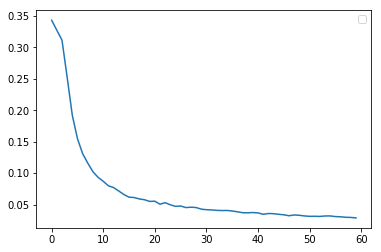

In [8]:
isTrained = False
model = None

if os.path.isfile('train_data.pt'):
    model = torch.load('train_data.pt')
    isTrained = True
else:
    model = NN()
    
model = NN()
    
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.8)

def train(epoch):
    model.train()
    for batch_id, (X, y) in enumerate(train_data):
        X = Variable(X)
        y = Variable(y)
        optimizer.zero_grad()
        y_pre = model(X)
        criterion = F.binary_cross_entropy
        loss = criterion(y_pre, y)
        loss.backward()
        optimizer.step()
        
        print('Train Epoch: {:2} [{:5} / {:5} ({:3.0f}%)]\tLoss: {:.6f} '.
              format(
                  epoch, 
                  batch_id * batch_size, 
                  len(train_data) * batch_size, 100. * batch_id / len(train_data), 
                  loss.data[0]
                  ))
        yield loss.data[0]

if not isTrained:
    training_loss = []
    for epoch in range(60):
        training_loss.append(np.mean(list(train(epoch))))

    plt.figure()
    plt.legend(loc='best')
    plt.plot(training_loss, label='Training loss')
    
    
    torch.save(model, 'train_data.pt')

## Evaluation

In [9]:
model.eval()
loss = 0
correct = 0

for X, y in test_data:
    X = Variable(X, volatile=True)
    y = Variable(y)
    y_pre = model(X)
    loss += (y.argmax(dim=1) != y_pre.argmax(dim=1)).sum()
    correct += (y.argmax(dim=1) == y_pre.argmax(dim=1)).sum()

loss = loss / len(test_data)

print('Average error: {}'.format(loss))
print('Accuracy: {:3.2f}%'.format(100. * correct / (len(test_data) * batch_size)))
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Average error: 2
Accuracy: 95.00%


## Test with real data
Now a test with real data is performed. I wrote the numbers from zero to nine on a piece of paper and photographed them (see below). The position of the numbers was entered manually.

![](HandwrittenNumbersTest.jpg)

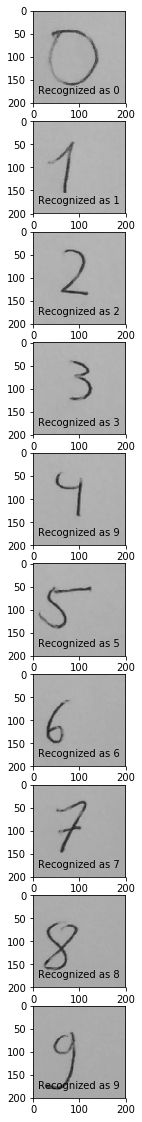

In [10]:
img = Image.open("./HandwrittenNumbersTest.jpg")
img = img.convert('L')

cords = [
    (733, 985), #0
    (973, 977), #1
    (1160, 1000), #2
    (1360, 1000), #3
    (1580, 1000), #4
    (1801, 1000), #5
    (2029, 1000), #6
    (2213, 1020), #7
    (2413, 1020), #8
    (2597, 1020)  #9
]

fig, axes = plt.subplots(len(cords), 1, figsize=(10, 20))

for i, (x, y) in enumerate(cords):
    copped = img.crop((x, y, x + 200, y + 200))
    
    img_tensor = transforms(copped)
    img_tensor.unsqueeze_(0)
    
    prediction = model(img_tensor)
    pre_number = prediction.argmax()
    
    axe = axes[i]
    axe.imshow(copped)
    axe.text(.5, .1, 'Recognized as {}'.format(pre_number), horizontalalignment='center', transform=axe.transAxes)

plt.show()